# Deep Learning Project Video Object Tracking


# Import dependancies

In [ ]:
import os, random, math, json, time
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from typing import Dict, List, Tuple, Optional
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict
from tqdm.auto import tqdm
import contextlib
from torch.optim.lr_scheduler import MultiStepLR

# Data Processing

## Load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Paths
PROJECT_DIR = "/content/drive/My Drive/CS5567_Deep_Learning_Project"
MOT16_DIR   = f"{PROJECT_DIR}/MOT16"
ARCHIVE     = f"{PROJECT_DIR}/MOT16.tar.gz"

# Create tar.gz inside CS5567_Deep_Learning_Project
!tar -czf "{ARCHIVE}" -C "{PROJECT_DIR}" MOT16

# Copy archive to Colab runtime
!cp "{ARCHIVE}" /content/

# Extract into /content/MOT16
!rm -rf /content/MOT16
!tar -xzf /content/MOT16.tar.gz -C /content/

In [ ]:
ROOT = Path("/content/MOT16")

# Train / Test folders
TRAIN_ROOT = ROOT / 'train'
TEST_ROOT  = ROOT / 'test'

# Quick sanity check to confirm folders exist
print("Train root:", TRAIN_ROOT.exists(), TRAIN_ROOT)
print("Test root:", TEST_ROOT.exists(), TEST_ROOT)

Train root: True /content/MOT16/train
Test root: True /content/MOT16/test


## Data Preprocessing

This is the documentation I used for the majority of the preprocessing.  Faster R-CNN fine tuning on a pre-trained model and testing is also on that page.  A lot of what we need can be found here.

https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Bounding box implementation documentation:

https://albumentations.ai/docs/3-basic-usage/bounding-boxes-augmentations/#augmenting-bounding-boxes-step-by-step

In [ ]:
# Config for data processing - Recommended by ChatGPT for explaining to teammates and passing information after
# providing code
class Cfg:
    KEEP_CLASSES = (1,)        # 1 = pedestrian in MOT16
    REQUIRE_CONF = True        # keep only conf==1 rows
    VIS_MIN = 0.0              # bump to 0.3 to drop heavy occlusions
    MIN_AREA = 20 * 20         # drop tiny boxes (pixels^2)

    BATCH_SIZE = 8
    NUM_WORKERS = 10
# tiny helpers
# Updates array to x's and y's from x,y,w,h
def xywh_to_xyxy(xywh: np.ndarray) -> np.ndarray:
    #[x,y,w,h] -> [x1,y1,x2,y2]
    out = xywh.copy()
    out[:,2] = xywh[:,0] + xywh[:,2]
    out[:,3] = xywh[:,1] + xywh[:,3]
    return out

# Clamp coords to image bounds = force all box corners to be inside the image so models don’t choke on invalid boxes.
# https://albumentations.ai/docs/3-basic-usage/bounding-boxes-augmentations/#augmenting-bounding-boxes-step-by-step
def clamp_boxes_xyxy(boxes: np.ndarray, W: int, H: int) -> np.ndarray:
    boxes[:,0] = np.clip(boxes[:,0], 0, W-1)
    boxes[:,1] = np.clip(boxes[:,1], 0, H-1)
    boxes[:,2] = np.clip(boxes[:,2], 0, W-1)
    boxes[:,3] = np.clip(boxes[:,3], 0, H-1)
    return boxes

def list_sequences(root: Path):
    #Return sorted list of sequence dirs under MOT16/train or test
    return sorted([p for p in root.iterdir() if p.is_dir()])

Config (Cfg)

KEEP_CLASSES = (1,)
MOT16 has labels for different object types. 1 = pedestrians. We keep only those rows so the detector trains on people.

REQUIRE_CONF = True
The 7th column in gt.txt is a validity flag (called “conf”): 1 = use this box, 0 = ignore region. When True, we drop anything with conf < 1 to avoid noisy labels.

VIS_MIN = 0.0
Minimum visible fraction (last column in gt.txt). Keep at 0.0 to use all boxes; raise to 0.3 if you want to exclude heavily occluded people.

MIN_AREA = 20 * 20
Filters out tiny boxes (in pixels²). Bump this if you see lots of tiny/noisy pedestrians that hurt training.

BATCH_SIZE = 2, NUM_WORKERS = 2
DataLoader settings. If you hit GPU OOM later with Faster R-CNN, set BATCH_SIZE = 1. Increase NUM_WORKERS if your CPU can preload faster.

Helper: xywh_to_xyxy(xywh)

What it does: Converts MOT16 box format from [x, y, w, h] (top-left + width/height) to the format TorchVision expects: [x1, y1, x2, y2].

Why: TorchVision detection models (e.g., Faster R-CNN) require XYXY coordinates.

How:

x2 = x + w

y2 = y + h
(x1 and y1 are just x and y)

Helper: clamp_boxes_xyxy(boxes, W, H)

What it does: Forces every box corner to lie inside the image: x ∈ [0, W-1], y ∈ [0, H-1].

Why: Conversions/rounding can push coordinates slightly outside the image (e.g., -1 or W+0.2). Out-of-bounds boxes can cause cropping errors or invalid areas during training.

When to tweak: You usually don’t. It’s a safety step. (Related reading on bbox validity: Albumentations bbox docs.)

Helper: list_sequences(root)

What it does: Returns a sorted list of sequence folders under MOT16/train (or MOT16/test), e.g., MOT16-02, MOT16-04, …

Why: Lets you dynamically enumerate sequences instead of hardcoding names. Useful for making train/val splits programmatically.

Quick usage notes for the team

If you want cleaner training data, try:

Cfg.VIS_MIN = 0.3 (skip heavily occluded pedestrians)

Cfg.MIN_AREA = 25*25 or 32*32 (skip tiny boxes)

If training crashes with memory errors:

Cfg.BATCH_SIZE = 1

These helpers are used upstream in the dataset:

xywh_to_xyxy → converts MOT16 to TorchVision format

clamp_boxes_xyxy → ensures boxes are valid before building targets

list_sequences → feeds your train/val split logic

In [ ]:
# Used MOT Challenge documentation for parsing, but we can change this:
# https://motchallenge.net/instructions/
def parse_gt_file(
    file_path: str | Path,
    keep_class_ids: Tuple[int, ...] = Cfg.KEEP_CLASSES,
    require_conf: bool = Cfg.REQUIRE_CONF,
    vis_min: float = Cfg.VIS_MIN,
) -> Dict[int, np.ndarray]:
    """
    Read one sequence's gt/gt.txt and return {frame_id: array Nx6}
    Each row: [track_id, x, y, w, h, class_id]
    Filters by class (pedestrians), conf==1 (if enabled), visibility >= vis_min,
    and drops degenerate boxes (w<=0 or h<=0).
    """
    fp = Path(file_path)
    frames: Dict[int, List[List[float]]] = {}

    with fp.open("r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 9:
                continue
            # MOT16 columns
            frame_id = int(parts[0])
            track_id = int(parts[1])
            x, y, w, h = map(float, parts[2:6])
            conf       = float(parts[6])  # GT validity flag (1 keep, 0 ignore)
            class_id   = int(parts[7])    # 1=pedestrian primary class
            vis        = float(parts[8])  # visible ratio 0..1

            if class_id not in keep_class_ids:
                continue
            if require_conf and conf < 1.0:
                continue
            if vis < vis_min:
                continue
            if w <= 0 or h <= 0:
                continue

            frames.setdefault(frame_id, []).append([track_id, x, y, w, h, class_id])

    # Convert lists → arrays; ensure empty frames become (0,6)
    return {
        fid: (np.array(rows, dtype=np.float32) if rows else np.zeros((0,6), np.float32))
        for fid, rows in frames.items()
    }

## Data Augmentation

Other potential transformations (like rotations) we can use:

https://github.com/facebookresearch/detectron2/blob/main/detectron2/data/transforms/transform.py#L501-L520

In [ ]:
# Color-only augmentation
def build_train_color_aug():
    """
    SAFE TRAIN AUGS:
      - ColorJitter + GaussianBlur + ToTensor
      - No flips/resizes/crops here (boxes remain valid as-is)
    """
    return transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
        transforms.ToTensor(),
    ])

def build_eval_tfms():
    """VAL/TEST: deterministic, just ToTensor()."""
    return transforms.Compose([
        transforms.ToTensor(),
    ])

## Save augmented images to a folder for reuse

In [ ]:
def save_augmented_dataset(dataset, save_dir="augmented_train"):
    """
    Apply dataset.transform to each image and save augmented images
    for consistency across training runs.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for idx in range(len(dataset)):
        img, target = dataset[idx]
        img_tensor = dataset.transform(img) if dataset.transform else img
        img_pil = TF.to_pil_image(img_tensor)
        save_path = save_dir / f"aug_{idx:06d}.jpg"
        img_pil.save(save_path)

    print(f"Saved {len(dataset)} augmented images → {save_dir}")


## Save augmented images to a folder for reuse

In [ ]:
save_dir = "/content/drive/MyDrive/mot16_artifacts/augmented_train"

def save_augmented_dataset(dataset, save_dir, seed_base=42, every=100):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    print("[save_augmented_dataset] saving to:", save_dir.resolve())

    n = len(dataset)
    print("[save_augmented_dataset] dataset length:", n)
    assert n > 0, "Dataset is empty. Build your dataset (train_sets[0]) first."

    saved = 0
    for idx in range(n):
        try:
            with torch.random.fork_rng(devices=[]):
                torch.manual_seed(seed_base + idx)
                img, _ = dataset[idx]   # __getitem__ already applies transforms

            if isinstance(img, torch.Tensor):
                img = TF.to_pil_image(img.cpu())

            out_path = save_dir / f"aug_{idx:06d}.jpg"
            img.save(out_path)
            saved += 1
            if (idx + 1) % every == 0 or idx == n - 1:
                print(f"[save_augmented_dataset] {idx+1}/{n} → {out_path}")
        except Exception as e:
            print(f"[save_augmented_dataset][WARN] failed on idx={idx}: {e}")
            traceback.print_exc(file=sys.stdout)

    print(f"[save_augmented_dataset] Saved {saved}/{n} images → {save_dir.resolve()}")
    print("[save_augmented_dataset] ls head:")
    for name in list(os.listdir(save_dir))[:5]:
        print("  ", name)


In [ ]:
train_seqs = list_sequences(TRAIN_ROOT)[:-1]
train_sets = [MOT16Detection(s, transform=build_train_color_aug()) for s in train_seqs]
save_augmented_dataset(train_sets[0], save_dir)


[save_augmented_dataset] saving to: /content/drive/MyDrive/mot16_artifacts/augmented_train
[save_augmented_dataset] dataset length: 600
[save_augmented_dataset] 100/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000099.jpg
[save_augmented_dataset] 200/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000199.jpg
[save_augmented_dataset] 300/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000299.jpg
[save_augmented_dataset] 400/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000399.jpg
[save_augmented_dataset] 500/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000499.jpg
[save_augmented_dataset] 600/600 → /content/drive/MyDrive/mot16_artifacts/augmented_train/aug_000599.jpg
[save_augmented_dataset] Saved 600/600 images → /content/drive/MyDrive/mot16_artifacts/augmented_train
[save_augmented_dataset] ls head:
   aug_000000.jpg
   aug_000001.jpg
   aug_000002.jpg
   aug_000003.jpg
   aug_000004.jpg


## MOT16 Faster R-CNN Dataset

In [ ]:
# MOT16 → Faster R-CNN Dataset
# Returns (image_tensor, target_dict) per frame
# target follows torchvision detection API

class MOT16Detection(Dataset):
    def __init__(self, seq_dir: Path, transform=None, min_area: int = Cfg.MIN_AREA):
        self.seq_dir = Path(seq_dir)
        self.img_dir = self.seq_dir / "img1"
        # parse once: frame_id -> Nx6 [track_id, x, y, w, h, class_id]
        self.gt_map  = parse_gt_file(self.seq_dir / "gt" / "gt.txt")
        self.frame_ids = sorted(self.gt_map.keys())
        self.transform = transform
        self.min_area = min_area

    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx: int):
        # pick one frame id
        fid = self.frame_ids[idx]

        # load image
        img_path = self.img_dir / f"{fid:06d}.jpg"  # MOT16 uses 6-digit names
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        # load all boxes for that frame (if any)
        rows = self.gt_map[fid]                          # [N,6]
        xywh = rows[:, 1:5] if rows.size else np.zeros((0,4), np.float32)
        xyxy = xywh_to_xyxy(xywh)                        # convert to [x1,y1,x2,y2]
        xyxy = clamp_boxes_xyxy(xyxy, W, H)              # keep boxes inside image

        # drop tiny boxes (prevents degenerate training)
        if xyxy.shape[0] > 0:
            wh = np.stack([xyxy[:,2]-xyxy[:,0], xyxy[:,3]-xyxy[:,1]], axis=1)
            areas = wh[:,0] * wh[:,1]
            keep = areas >= self.min_area
            xyxy = xyxy[keep]

        # build the target dict as torchvision expects
        boxes  = torch.as_tensor(xyxy, dtype=torch.float32)              # [N,4]
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)        # all pedestrians → class 1
        area   = ((boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])        # [N]
                  if boxes.numel() else torch.zeros(0))
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.uint8)      # no crowds in GT

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([fid], dtype=torch.int64),
            "area": area,
            "iscrowd": iscrowd,
        }

        # apply COLOR-ONLY aug so boxes remain valid (no flips/resizes here)
        if self.transform is not None:
            img = self.transform(img)   # -> Tensor [C,H,W]

        return img, target

In [ ]:
# Collate: detection models need lists (variable #boxes per image)
# Function found here: https://github.com/pytorch/vision/blob/main/references/detection/utils.py
def det_collate(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

# Build train/val loaders from lists of sequence paths
def build_det_loaders(train_seqs, val_seqs):
    train_tfm = build_train_color_aug()  # safe augment vs more complex options
    val_tfm   = build_eval_tfms()        # deterministic

    train_sets = [MOT16Detection(s, transform=train_tfm) for s in train_seqs]
    val_sets   = [MOT16Detection(s, transform=val_tfm)   for s in val_seqs]

    # multiple sequences, join them end-to-end
    # https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.ConcatDataset
    train_ds = ConcatDataset(train_sets) if len(train_sets) > 1 else train_sets[0]
    val_ds   = ConcatDataset(val_sets)   if len(val_sets) > 1   else val_sets[0]

    train_ld = DataLoader(train_ds, batch_size=Cfg.BATCH_SIZE, shuffle=True,
                          num_workers=Cfg.NUM_WORKERS, collate_fn=det_collate)
    val_ld   = DataLoader(val_ds, batch_size=Cfg.BATCH_SIZE, shuffle=False,
                          num_workers=Cfg.NUM_WORKERS, collate_fn=det_collate)
    return train_ld, val_ld, train_sets

## Sanity checks

In [ ]:
# Confirm sequence has the expected files
def validate_sequence_layout(seq: Path):
    if not (seq / "img1").is_dir():
        raise FileNotFoundError(f"Missing folder: {seq}/img1")
    if not (seq / "gt" / "gt.txt").exists():
        raise FileNotFoundError(f"Missing file: {seq}/gt/gt.txt")
    print(f"[OK] {seq.name}: has img1/ and gt/gt.txt")

# Draw GT boxes on one sample (to eyeball correctness)
def preview_sample(dataset: MOT16Detection, i: int = 0, save_path: Optional[Path] = None):
    img, tgt = dataset[i]
    # img is Tensor [C,H,W] → convert to uint8 HxWxC for drawing
    arr = (img.permute(1,2,0).numpy() * 255).clip(0,255).astype(np.uint8)
    pil = Image.fromarray(arr)
    draw = ImageDraw.Draw(pil)
    for x1,y1,x2,y2 in tgt["boxes"].tolist():
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=2)
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        pil.save(save_path)
        print(f"[OK] wrote {save_path}")
    else:
        pil.show()

In [ ]:
# 1) list all train sequences under Drive
train_seqs_all = list_sequences(TRAIN_ROOT)  # from your code above
assert len(train_seqs_all) > 1, "Expected multiple sequences under MOT16/train"

# 2) simple split: last one as val
val_seqs   = [train_seqs_all[-1]]
train_seqs = train_seqs_all[:-1]

# 3) layout check on one train + the val
validate_sequence_layout(train_seqs[0])
validate_sequence_layout(val_seqs[0])

# 4) build loaders (this is what your detector will import/use)
train_loader, val_loader, train_sets = build_det_loaders(train_seqs, val_seqs)

# 5) visual sanity check: save one frame with GT boxes rendered
preview_sample(train_sets[0], i=0, save_path=Path("./mot16_preview.png"))

# 6) confirm batch structure matches what Faster R-CNN expects
images, targets = next(iter(train_loader))
print(type(images), len(images), images[0].shape)                 # list, B, [C,H,W]
print(targets[0].keys(), targets[0]["boxes"].shape)               # dict keys + [N,4]

[OK] MOT16-02: has img1/ and gt/gt.txt
[OK] MOT16-13: has img1/ and gt/gt.txt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[OK] wrote mot16_preview.png
<class 'list'> 8 torch.Size([3, 1080, 1920])
dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd']) torch.Size([34, 4])


In [ ]:
print(f"Train sequences: {[s.name for s in train_seqs]}")
print(f"Val sequences:   {[s.name for s in val_seqs]}")
preview_sample(train_sets[0], i=0, save_path=Path('./mot16_preview.png'))

Train sequences: ['MOT16-02', 'MOT16-04', 'MOT16-05', 'MOT16-09', 'MOT16-10', 'MOT16-11']
Val sequences:   ['MOT16-13']
[OK] wrote mot16_preview.png


In [ ]:
# FAST stats: zero image I/O
total_frames = total_boxes = empty = 0
for ds in train_sets:
    for fid in ds.frame_ids:
        n = ds.gt_map[fid].shape[0]
        total_frames += 1
        total_boxes  += n
        empty        += int(n == 0)

print(f"frames={total_frames}, boxes={total_boxes}, "
      f"mean_boxes/frame={total_boxes/max(1,total_frames):.2f}, "
      f"empty_frames={empty}")


frames=4566, boxes=98957, mean_boxes/frame=21.67, empty_frames=0


# Quick Chat GPT breakdown of everything completed:
1. Ground-Truth Parsing
Function: parse_gt_file
Handles:
Reads gt/gt.txt for each sequence
Keeps only class_id == 1 (pedestrians)
Skips rows where conf < 1.0
Optionally filters by Cfg.VIS_MIN and Cfg.MIN_AREA
Why it matters: Ensures clean training data and removes invalid or tiny boxes.

2. Data Augmentation
Function: build_train_color_aug()
Includes:
ColorJitter for brightness/contrast/saturation variation
GaussianBlur for photometric noise
ToTensor() conversion for TorchVision models
Safe: Does not modify box coordinates (no flips/resizes → boxes stay valid).

3. Dataset
Class: MOT16Detection
Returns (image, target) where:
image: Tensor [C,H,W]
target: Dict with keys boxes, labels, image_id, area, iscrowd
Follows TorchVision detection API → works with fasterrcnn_resnet50_fpn out of the box.

4. Collate & DataLoaders
Function: det_collate — returns lists of images and targets (supports variable #boxes).
Function: build_det_loaders(train_seqs, val_seqs) — builds:
train_loader (with augmentation)
val_loader (no augmentation)
train_sets (to preview/debug individual frames)

5. Sanity Tools
validate_sequence_layout(seq) — confirms folder structure and GT presence.
preview_sample(dataset, i) — draws boxes on image to visually verify correctness.
Prints batch shape + keys for teammates so they know exactly what they’re getting.


If memory gets tight when they train Faster R-CNN: set Cfg.BATCH_SIZE = 1.
To reduce noisy labels: try Cfg.VIS_MIN = 0.3 and/or raise Cfg.MIN_AREA.


Model teammate: can directly pass train_loader, val_loader into their Faster R-CNN training loop.

Re-ID / Siamese teammate: can use the same parse_gt_file and image/box format if they build a crop-based dataset.

Detection/Tracking teammate: has clean, validated data and no risk of invalid boxes.

# Faster R-CNN few-shot fine-tuning

## Quick orientation before fine-tuning Faster R-CNN


Quick orientation before fine-tuning Faster R-CNN:
- Peek a single sample (tensor shape + target keys)
- Visualize 1 frame with GT boxes ( sanity look )
- Inspect one batch (types/shapes) from train_loader

Assumes the previous cells already defined:
- train_sets, val_seqs, train_loader, val_loader

In [ ]:
# Pick the first sequence dataset prepared earlier
ds = train_sets[0]
img, tgt = ds[0]

print("Image:", type(img), img.shape)
print("Target keys:", list(tgt.keys()))
print("Boxes shape:", tgt["boxes"].shape)
print("Labels unique:", tgt["labels"].unique().tolist())
print("Image ID:", tgt["image_id"].item())


Image: <class 'torch.Tensor'> torch.Size([3, 1080, 1920])
Target keys: ['boxes', 'labels', 'image_id', 'area', 'iscrowd']
Boxes shape: torch.Size([20, 4])
Labels unique: [1]
Image ID: 1


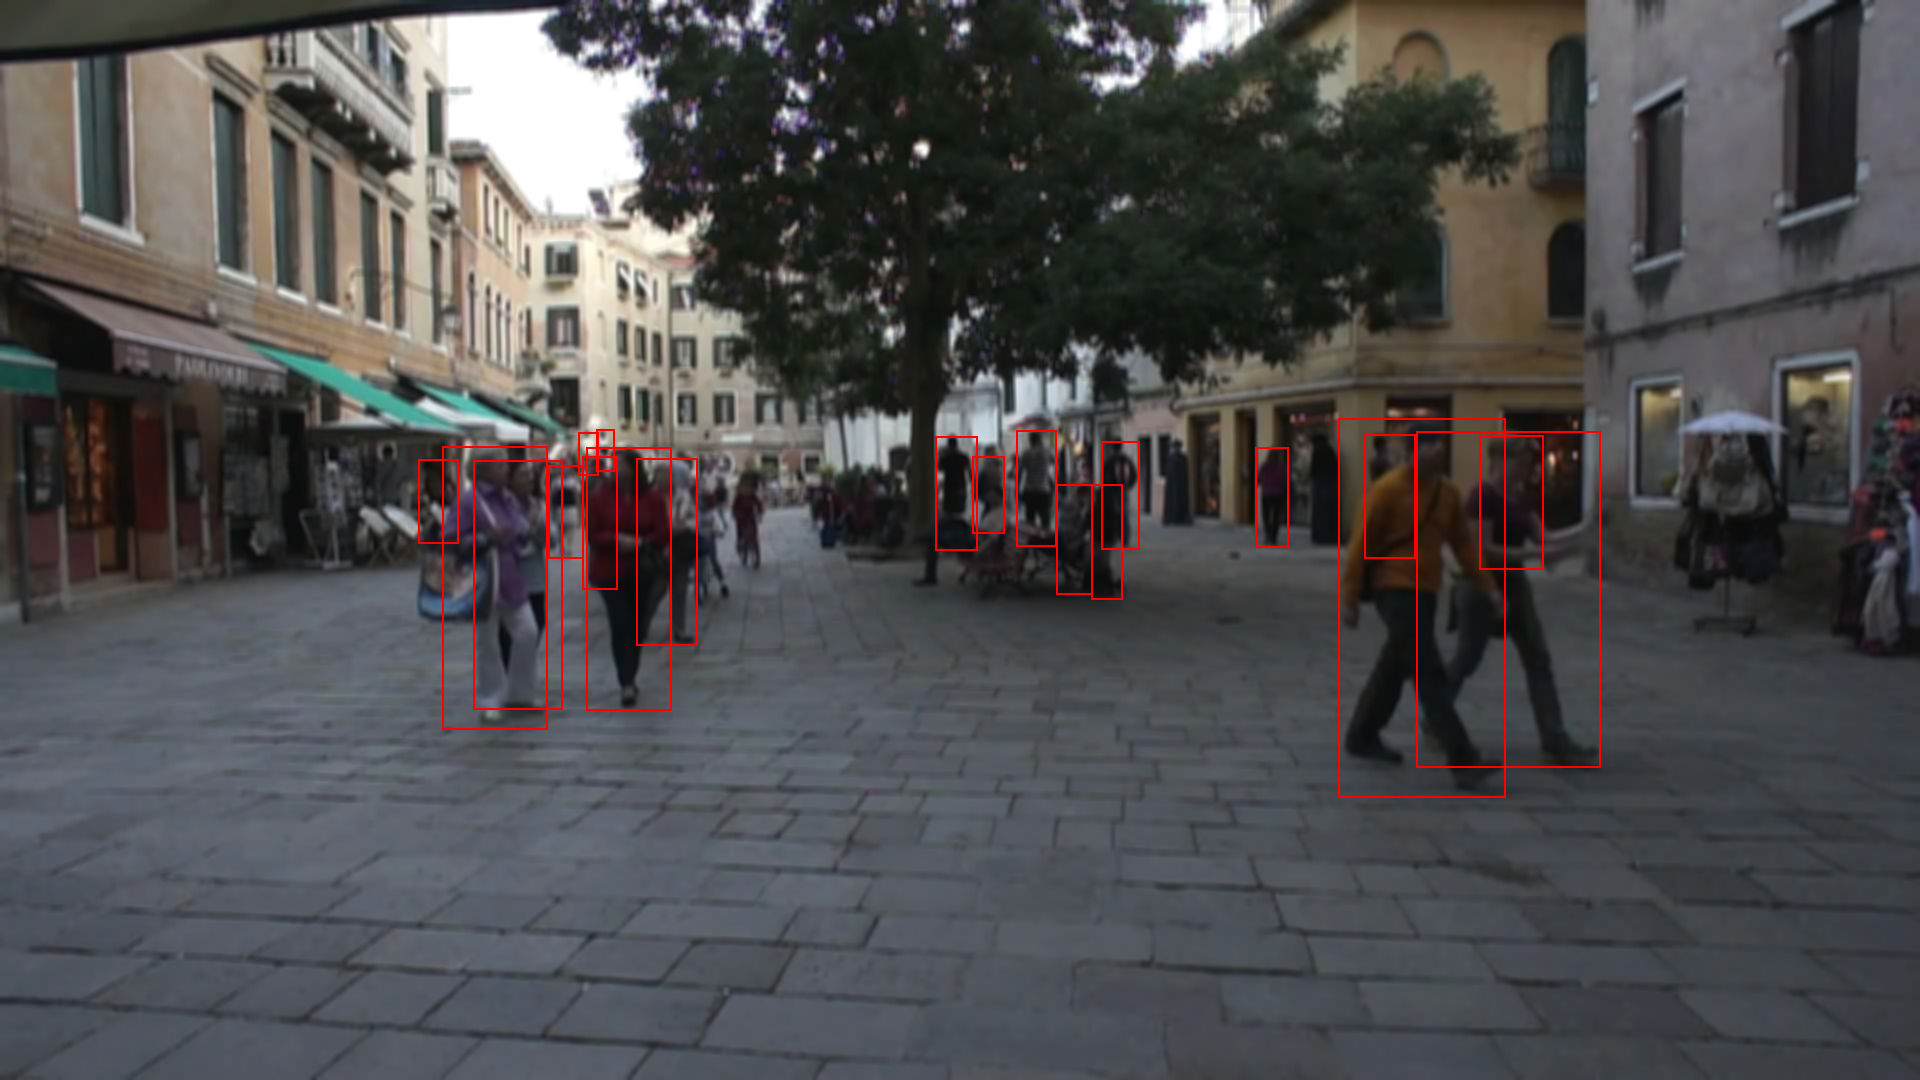

In [ ]:
# Preview sample
arr = (img.permute(1,2,0).numpy() * 255).clip(0,255).astype("uint8")
pil = Image.fromarray(arr)
draw = ImageDraw.Draw(pil)
for x1, y1, x2, y2 in tgt["boxes"].tolist():
    draw.rectangle([x1, y1, x2, y2], outline=(255,0,0), width=2)
display(pil)

In [ ]:
images, targets = next(iter(train_loader))

print(f"Batch size: {len(images)}")
print("images[0].shape:", images[0].shape)
print("targets[0] keys:", list(targets[0].keys()))
print("targets[0]['boxes'].shape:", targets[0]["boxes"].shape)
print("labels example:", targets[0]["labels"][:5].tolist())

Batch size: 8
images[0].shape: torch.Size([3, 1080, 1920])
targets[0] keys: ['boxes', 'labels', 'image_id', 'area', 'iscrowd']
targets[0]['boxes'].shape: torch.Size([9, 4])
labels example: [1, 1, 1, 1, 1]


## Config (CFG): what each key does & how to tune it

This config controls **model behavior**, **training speed**, **dataloader throughput**, and **what gets saved**.

| Key | What it controls | Raise it → | Lower it → | Default here |
|---|---|---|---|---|
| `num_classes` | # categories the detector predicts (background is implicit) | — | — | `2` (pedestrian=1) |
| `freeze_backbone` | Keep ResNet backbone frozen (few-shot friendly) | More stable, faster; may cap accuracy | More capacity; risk overfit | `True` |
| `epochs` | How many passes over training data | More training; risk overfit after a point | Faster runs; possible underfit | `12` |
| `batch_size` | Images per step | Better GPU utilization (needs more VRAM); you can scale LR ≈ linearly | Less VRAM use; slower throughput | `8` |
| `num_workers` | Parallel data loading processes | Faster input pipeline (until CPU/disk saturate) | Safer on small CPUs; may starve GPU | `min(os.cpu_count(), 12)` |
| `pin_memory` | Page-lock host RAM for fast H2D copies | Enables non-blocking `.to(device)` | Slightly less host RAM use | `True` |
| `prefetch_factor` | Batches queued per worker | Smoother feeding; more RAM | Less RAM; possible stalls | `4` |
| `persistent_workers` | Keep workers alive across epochs | Less restart overhead | Small memory savings | `True` |
| `lr` | Learning rate (SGD step size) | Faster learning; risk divergence | More stable; slower | `0.005` |
| `momentum` | SGD momentum | Smoother updates | Noisier updates | `0.9` |
| `weight_decay` | L2 regularization | Less overfit; too high slows learning | More overfit risk | `5e-4` |
| `score_thresh` | Min confidence to keep a box (post-NMS) | Fewer boxes; higher precision, lower recall | More boxes; higher recall, more FPs | `0.5` (final value is chosen by sweep) |
| `iou_thresh` | IoU used to count a “hit” during eval | Stricter matching -> lower recall | Looser matching -> higher recall | `0.5` |
| `use_amp` | Mixed precision training | Big speed + memory win on GPU | Full FP32; slower but simpler | `True` |
| `use_tf32` | TF32 math on Ampere+ (A100) | More speed with tiny accuracy impact | Exact FP32 matmul | `True` |
| `cudnn_benchmark` | Auto-tune kernels for current shapes | Faster after warm-up | Deterministic but slower | `True` |
| `artifact_dir` | Where checkpoints/logs/exports go | — | — | `/content/drive/My Drive/CS5567_Deep_Learning_Project` |

### Quick rules of thumb

- **Batch size ↔ LR:** By changing `batch_size` (e.g., 8 -> 12), we can scale `lr` roughly proportionally (`lr *= new_bs / old_bs`). Always watch validation metrics.
- **Feeding the GPU:** If utilization is low, try increasing `num_workers` (8 - 12), keep `pin_memory=True`, and try `prefetch_factor=4 - 8`. If Colab warns about too many workers, back off.
- **Freezing vs unfreezing:** Start with `freeze_backbone=True` (heads-only). If val recall stalls, unfreeze just **`layer4`** for 3 - 5 extra epochs at a **smaller LR** (e.g., `5e-4`).
- **Threshold selection:** After training, run the **threshold sweep** on the **validation** set and let it set the best value
- **What “good” looks like here:** Train loss trending down; val recall@0.5 around ~0.75 - 0.85 with a reasonable number of boxes/image.

### What gets saved (under `artifact_dir`)
- `checkpoints/`
  - `fasterrcnn_last.pt` - latest weights
  - `fasterrcnn_best.pt` - best by val recall
- `training_log.json` — per-epoch `{epoch, train_loss, val_recall, sec, lr}`
- `samples/val_pred_*.png` - predicted boxes on a few val images at the chosen threshold
- `detections_val.jsonl` - one line per frame: `{image_id, boxes:[[x1,y1,x2,y2],...], scores:[...]}` for the tracking stage


## Key metrics & terms you’ll see in this section

### Training vs Validation
- **Training loss**  
  What the model is trying to minimize **on training batches**. For Faster R-CNN it’s a sum of pieces (RPN objectness + RPN box regression + ROI classification + ROI box regression). Lower is better **on train**, but it doesn’t guarantee generalization.

- **Validation loss**  
  Same idea but computed on the **validation set** (no gradient updates). If train loss keeps falling while val loss/metrics stop improving or worsen -> **overfitting**.

> Loss ≠ accuracy. That’s why we also report recall and do a threshold sweep.

---

### IoU (Intersection over Union)
How much a predicted box overlaps a ground-truth (GT) box.

**Mini-example:**  
GT = 50×50 box (=2500 px²), Pred = 50×50, overlap = 30×30 (=900).  
Union = 2500 + 2500 − 900 = 4100 -> **IoU = 900/4100 ≈ 0.22** (not a match at IoU 0.5).

We often say “a detection **counts** if IoU ≥ **0.5**” (that's `iou_thresh`).

---

### Recall, Precision, F1
- **Recall** (we use this as our main validation metric):  
  “Of all GT boxes, how many did we find?”  

  *Example:* 100 GT boxes; 72 have a matching prediction -> **recall = 0.72**.

- **Precision:**  
  “Of all predictions we kept, how many are correct?”  

- **F1 score:** harmonic mean of precision and recall, balances both.  
  We pick threshold by **recall** for tracking (don’t miss people).

---

### Confidence score & `score_thresh`
Each predicted box gets a **confidence** (probability of being a person).  
We then **drop** boxes with score < `score_thresh`.  
- Lower threshold -> **more boxes**, higher recall, more false positives.  
- Higher threshold -> **fewer boxes**, lower recall, cleaner outputs.

**Threshold sweep** (the cell we run after training) tries a few thresholds (e.g., 0.35–0.60), reports recall and “avg preds per image,” then **sets** `CFG["score_thresh"]` to the best one (by recall) and exports detections for Re-ID.

---

### Optimizer knobs (why they matter)
- **Learning rate (`lr`)**: step size. Too high -> divergence; too low -> slow.  
- **Momentum (`momentum`)**: smooths updates; 0.9 is a solid default.  
- **Weight decay (`weight_decay`)**: L2 regularization to reduce overfit.
- **LR scheduler (MultiStepLR)**: drops LR at epochs **6** and **10** by ×0.1 to fine-tune later training.

---

### Dataloader/perf knobs (feeding the GPU)
- **`batch_size`**: images per step. Larger -> faster throughput if VRAM allows.  
- **`num_workers`**: parallel CPU loaders; more until CPU/disk saturate.  
- **`pin_memory`**: faster host -> GPU copies.  
- **`prefetch_factor`, `persistent_workers`**: keep a queue of ready batches, avoid worker restarts each epoch.

---

### AMP / TF32 / cuDNN benchmark
- **AMP (`use_amp`)**: mixed precision -> faster + less VRAM on GPU.  
- **TF32 (`use_tf32`)**: fast matmul on A100-class GPUs, tiny accuracy impact.  
- **cuDNN benchmark**: autotunes kernels for your image shapes -> faster after warm-up.

---

### Checkpoints & exports
- **`fasterrcnn_last.pt`**: latest weights (resuming continues from here).  
- **`fasterrcnn_best.pt`**: best so far by validation recall.  
- **`detections_val.jsonl`**: one line per frame:
  ```json
  {"image_id": 123, "boxes": [[x1,y1,x2,y2], ...], "scores": [ ... ]}


## Setup config + device + seeds

In [ ]:
CFG = {
    # model / training
    "num_classes": 2,
    "freeze_backbone": True,
    "epochs": 12,

    # dataloader
    "batch_size": 8,
    "num_workers": min(os.cpu_count() or 2, 12),
    "pin_memory": True,
    "prefetch_factor": 4,
    "persistent_workers": True,

    # optimization
    "lr": 0.005,
    "momentum": 0.9,
    "weight_decay": 5e-4,

    # eval/export
    "score_thresh": 0.5,
    "iou_thresh": 0.5,

    # speed toggles
    "use_amp": True,            # mixed precision
    "use_tf32": True,           # Ampere fast matmul
    "cudnn_benchmark": True,    # autotune kernels

    # artifacts
    "artifact_dir": "/content/drive/My Drive/CS5567_Deep_Learning_Project",
}

ART = Path(CFG["artifact_dir"])
(ART / "checkpoints").mkdir(parents=True, exist_ok=True)
(ART / "samples").mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

print(f"[ok] device={device}  artifacts={ART}")
print(f"[cfg] bs={CFG['batch_size']} workers={CFG['num_workers']} pin={CFG['pin_memory']} prefetch={CFG['prefetch_factor']}")

[ok] device=cuda  artifacts=/content/drive/My Drive/CS5567_Deep_Learning_Project
[cfg] bs=8 workers=12 pin=True prefetch=4


In [ ]:
# Fast paths & AMP
torch.backends.cudnn.benchmark = CFG["cudnn_benchmark"]
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = CFG["use_tf32"]
    torch.backends.cudnn.allow_tf32 = CFG["use_tf32"]

use_amp = (device == "cuda") and CFG["use_amp"]
scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)
amp_ctx = torch.amp.autocast('cuda', enabled=use_amp) if use_amp else contextlib.nullcontext()

print(f"[speed] AMP={use_amp} TF32={torch.backends.cuda.matmul.allow_tf32} cuDNN_bench={torch.backends.cudnn.benchmark}")

[speed] AMP=True TF32=True cuDNN_bench=True


In [ ]:
# Rebuild DataLoaders with CFG

bs       = CFG.get("batch_size",      train_loader.batch_size or 2)
workers  = CFG.get("num_workers",     max(2, train_loader.num_workers))
pin      = CFG.get("pin_memory",      True)
prefetch = CFG.get("prefetch_factor", 4)
persist  = CFG.get("persistent_workers", True)

collate  = train_loader.collate_fn
train_ds = train_loader.dataset
val_ds   = val_loader.dataset

train_loader = DataLoader(
    train_ds,
    batch_size=bs, shuffle=True,
    num_workers=workers, pin_memory=pin,
    prefetch_factor=prefetch, persistent_workers=persist,
    collate_fn=collate,
)

val_loader = DataLoader(
    val_ds,
    batch_size=bs, shuffle=False,
    num_workers=max(2, workers // 2), pin_memory=pin,
    prefetch_factor=max(2, prefetch // 2), persistent_workers=persist,
    collate_fn=collate,
)

## Helper Functions

In [ ]:
def save_ckpt(tag, model, optimizer, epoch, best_recall, cfg):
    path = ART / "checkpoints" / f"fasterrcnn_{tag}.pt"
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "best_recall": best_recall,
        "config": cfg,
    }, path)
    return path

def load_ckpt(path, model, optimizer=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None and "optimizer" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer"])
    return ckpt

@torch.no_grad()
def draw_boxes(img_tensor, boxes, scores=None, score_thresh=0.5):
    img = transforms.ToPILImage()(img_tensor.cpu())
    draw = ImageDraw.Draw(img)
    for i, b in enumerate(boxes):
        if scores is not None and scores[i] < score_thresh:
            continue
        x1,y1,x2,y2 = [float(v) for v in b]
        draw.rectangle([x1,y1,x2,y2], outline="red", width=2)
        if scores is not None:
            draw.text((x1, max(0,y1-10)), f"{scores[i]:.2f}", fill="red")
    return img

@torch.no_grad()
def evaluate_recall(model, val_loader, iou_thresh=0.5, score_thresh=0.5, max_batches=None):
    model.eval()
    total_gt = 0
    total_hit = 0
    seen = 0
    for b_idx, (images, targets) in enumerate(val_loader):
        images = [im.to(device) for im in images]
        outputs = model(images)
        for out, tgt in zip(outputs, targets):
            pred_boxes = out["boxes"][out["scores"] >= score_thresh]
            gt_boxes   = tgt["boxes"]
            total_gt += gt_boxes.size(0)
            if gt_boxes.numel() and pred_boxes.numel():
                ious = box_iou(gt_boxes.to(device), pred_boxes.to(device)).cpu().numpy()
                hit = (ious.max(axis=1) >= iou_thresh).sum()
                total_hit += int(hit)
        seen += 1
        if max_batches and seen >= max_batches:
            break
    recall = (total_hit / total_gt) if total_gt else 0.0
    return recall

@torch.no_grad()
def save_val_samples(model, val_loader, n_images=6, score_thresh=0.5):
    model.eval()
    saved = 0
    for images, targets in val_loader:
        images_cpu = [im.cpu() for im in images]
        outputs = model([im.to(device) for im in images])
        for img_t, out in zip(images_cpu, outputs):
            boxes = out["boxes"].cpu()
            scores = out["scores"].cpu()
            img = draw_boxes(img_t, boxes, scores, score_thresh=score_thresh)
            out_path = ART / "samples" / f"val_pred_{saved:03d}.png"
            img.save(out_path)
            saved += 1
            if saved >= n_images:
                print(f"[ok] saved {saved} samples → {ART/'samples'}")
                return

@torch.no_grad()
def export_detections_jsonl(model, loader, out_path, score_thresh=0.5):
    model.eval()
    with open(out_path, "w") as f:
        for images, targets in loader:
            outputs = model([im.to(device) for im in images])
            for out, tgt in zip(outputs, targets):
                image_id = int(tgt["image_id"].item())
                keep = out["scores"] >= score_thresh
                boxes = out["boxes"][keep].cpu().numpy().tolist()
                scores = out["scores"][keep].cpu().numpy().tolist()
                rec = {"image_id": image_id, "boxes": boxes, "scores": scores}
                f.write(json.dumps(rec) + "\n")
    print(f"[ok] wrote detections → {out_path}")

## Model init + optimizer + scheduler + resume

In [ ]:
# --- build model from pretrained ---
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, CFG["num_classes"])

# freeze backbone
if CFG.get("freeze_backbone", True):
    for p in model.backbone.parameters():
        p.requires_grad = False

model = model.to(device)

# --- optimizer + LR scheduler ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=CFG["lr"], momentum=CFG["momentum"], weight_decay=CFG["weight_decay"]
)
scheduler = MultiStepLR(optimizer, milestones=[6, 10], gamma=0.1)  # keep ONE scheduler

print("[ok] model ready | trainable params:", sum(p.numel() for p in params))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 244MB/s]


[ok] model ready | trainable params: 14499865


In [ ]:
# --- resume (last > best > scratch) ---
ckpt_last = ART / "checkpoints" / "fasterrcnn_last.pt"
ckpt_best = ART / "checkpoints" / "fasterrcnn_best.pt"

start_epoch = 0
best_recall = -1.0

def load_ckpt(path, model, optimizer=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"])
    if optimizer is not None and "optimizer" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer"])
    return ckpt

if ckpt_last.exists():
    ck = load_ckpt(ckpt_last, model, optimizer, map_location=device)
    start_epoch = ck.get("epoch", -1) + 1
    best_recall = ck.get("best_recall", -1.0)
    print(f"[resume] LAST → start at epoch {start_epoch} (best_recall={best_recall:.3f})")
elif ckpt_best.exists():
    ck = load_ckpt(ckpt_best, model, optimizer=None, map_location=device)
    best_recall = ck.get("best_recall", -1.0)
    print(f"[resume] BEST weights loaded (optimizer fresh) (best_recall={best_recall:.3f})")
else:
    print("[resume] no checkpoint found → start from scratch")

# align scheduler state with resumed epoch index
scheduler.last_epoch = start_epoch - 1

# prepare/continue training log
log_path = ART / "training_log.json"
try:
    logs = json.loads(log_path.read_text()) if log_path.exists() else []
except Exception:
    logs = []

[resume] LAST → start at epoch 10 (best_recall=0.740)


## Train + checkpoints + logs

In [ ]:
for epoch in range(start_epoch, CFG["epochs"]):
    model.train()
    t0 = time.time()
    running = defaultdict(float)

    for step, (images, targets) in enumerate(tqdm(train_loader, desc=f"epoch {epoch}"), 1):
        images  = [im.to(device, non_blocking=True) for im in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)

        with amp_ctx:
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        for k, v in loss_dict.items():
            running[k] += float(v.item())

    # ---- end of epoch: metric + log + ckpt ----
    train_loss = sum(running.values())
    val_recall = evaluate_recall(
        model, val_loader,
        iou_thresh=CFG["iou_thresh"],
        score_thresh=CFG["score_thresh"]
    )
    dt = time.time() - t0

    logs.append({
        "epoch": epoch,
        "train_loss": round(train_loss, 4),
        "val_recall@0.5": round(val_recall, 4),
        "sec": round(dt, 1),
        "lr": optimizer.param_groups[0]["lr"],
    })
    with open(log_path, "w") as f:
        json.dump(logs, f, indent=2)

    save_ckpt("last", model, optimizer, epoch, best_recall, CFG)
    if val_recall > best_recall:
        best_recall = val_recall
        save_ckpt("best", model, optimizer, epoch, best_recall, CFG)
        tag = f"**BEST** → {best_recall:.3f}"
    else:
        tag = ""
    print(f"epoch {epoch:02d} | train_loss={train_loss:.3f} | val_recall={val_recall:.3f} | {dt:.1f}s {tag}")

    scheduler.step()


epoch 10:   0%|          | 0/571 [00:00<?, ?it/s]

epoch 10 | train_loss=260.594 | val_recall=0.652 | 727.5s 


epoch 11:   0%|          | 0/571 [00:00<?, ?it/s]

epoch 11 | train_loss=259.349 | val_recall=0.657 | 251.3s 


In [ ]:
# Try a few thresholds
thrs = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
iou  = CFG.get("iou_thresh", 0.5)

# Load best weights for evaluation if available
best_ckpt = ART / "checkpoints" / "fasterrcnn_best.pt"
if best_ckpt.exists():
    _ = load_ckpt(best_ckpt, model, optimizer=None, map_location=device)
    print("[info] loaded best weights for sweep")

# Evaluate recall IoU and average number of kept boxes per image
rows = []
model.eval()
with torch.no_grad():
    for t in thrs:
        # Recall at IoU (counts how many GT boxes are hit)
        r = evaluate_recall(model, val_loader, iou_thresh=iou, score_thresh=t)

        # Simple proxy for false positives: how many preds we keep per image?
        total_pred = total_gt = total_img = 0
        for images, targets in val_loader:
            outputs = model([im.to(device) for im in images])
            for o, tgt in zip(outputs, targets):
                keep = (o["scores"] >= t)
                total_pred += int(keep.sum().item())
                total_gt   += int(tgt["boxes"].size(0))
                total_img  += 1

        rows.append({
            "thr": float(t),
            "recall": float(r),
            "avg_preds_per_img": round(total_pred / max(1, total_img), 2),
            "avg_gt_per_img": round(total_gt   / max(1, total_img), 2)
        })

[info] loaded best weights for sweep


In [ ]:
# Print a table
print(f"thr  | recall@IoU={iou:.2f} | avg preds/img | avg gt/img")
for r in rows:
    print(f"{r['thr']:.2f} | {r['recall']:.3f}        | {r['avg_preds_per_img']:.2f}          | {r['avg_gt_per_img']:.2f}")

# Choose the threshold with the highest recall
best = max(rows, key=lambda d: d["recall"])
CFG["score_thresh"] = float(best["thr"])
print(f"\n[chosen] score_thresh = {CFG['score_thresh']} (highest recall on val).")

# Save a few visuals at the chosen threshold + export detections for tracker
save_val_samples(model, val_loader, n_images=8, score_thresh=CFG["score_thresh"])
export_detections_jsonl(
    model, val_loader,
    out_path=str(ART / "detections_val.jsonl"),
    score_thresh=CFG["score_thresh"]
)
print("[ok] wrote samples →", ART / "samples")
print("[ok] wrote detections →", ART / "detections_val.jsonl")

thr  | recall@IoU=0.50 | avg preds/img | avg gt/img
0.35 | 0.789        | 24.09          | 15.17
0.40 | 0.773        | 21.88          | 15.17
0.45 | 0.756        | 19.91          | 15.17
0.50 | 0.740        | 18.26          | 15.17
0.55 | 0.723        | 16.68          | 15.17
0.60 | 0.704        | 15.21          | 15.17

[chosen] score_thresh = 0.35 (highest recall on val).
[ok] saved 8 samples → /content/drive/My Drive/CS5567_Deep_Learning_Project/samples
[ok] wrote detections → /content/drive/My Drive/CS5567_Deep_Learning_Project/detections_val.jsonl
[ok] wrote samples → /content/drive/My Drive/CS5567_Deep_Learning_Project/samples
[ok] wrote detections → /content/drive/My Drive/CS5567_Deep_Learning_Project/detections_val.jsonl


# Train the Siamese Network for Re-ID

### Prepare Dataset for Siamese Training

This step involves extracting image crops for each person (track) across the frames and organizing them to create pairs or triplets for Siamese network training.

First, we'll extract and save the cropped images for each unique track ID.

In [ ]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm

# TRAIN_ROOT = Path("/content/MOT16/train")

# Directory to save cropped images
CROPPED_IMAGES_DIR = ART / "cropped_train_persons"
CROPPED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Saving cropped images to: {CROPPED_IMAGES_DIR}")

# Get all training sequences
train_seqs = list_sequences(TRAIN_ROOT) # Assuming list_sequences is defined

track_image_paths = defaultdict(list)

# Iterate through each sequence
for seq_dir in tqdm(train_seqs, desc="Processing Sequences"):
    gt_file = seq_dir / "gt" / "gt.txt"
    if not gt_file.exists():
        print(f"Warning: GT file not found for sequence {seq_dir}. Skipping.")
        continue

    # Parse ground truth for this sequence
    # The output is {frame_id: array Nx6 [track_id, x, y, w, h, class_id]}
    gt_data = parse_gt_file(gt_file)

    img_dir = seq_dir / "img1"

    # Iterate through frames with detections
    for frame_id, detections in sorted(gt_data.items()):
        if len(detections) == 0:
            continue # Skip frames with no ground truth boxes (after filtering)

        img_path = img_dir / f"{frame_id:06d}.jpg"
        if not img_path.exists():
            print(f"Warning: Image file not found for frame {frame_id} in {seq_dir}. Skipping.")
            continue

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Could not open image file {img_path}: {e}. Skipping.")
            continue

        W, H = img.size

        # Process each detection in the frame
        for det in detections:
            track_id, x, y, w, h, class_id = det

            # Convert xywh to xyxy and clamp (using helpers from earlier)
            box_xywh = np.array([[x, y, w, h]], dtype=np.float32)
            box_xyxy = xywh_to_xyxy(box_xywh)[0]
            box_xyxy = clamp_boxes_xyxy(np.array([box_xyxy], dtype=np.float32), W, H)[0]

            x1, y1, x2, y2 = [int(round(c)) for c in box_xyxy]

            # Ensure valid box before cropping
            if x2 > x1 and y2 > y1:
                try:
                    cropped_img = img.crop((x1, y1, x2, y2))

                    # Define save path: CROPPED_IMAGES_DIR / sequence_name / track_id / frame_id.jpg
                    save_subdir = CROPPED_IMAGES_DIR / seq_dir.name / str(int(track_id))
                    save_subdir.mkdir(parents=True, exist_ok=True)
                    save_path = save_subdir / f"{frame_id:06d}.jpg"

                    cropped_img.save(save_path)
                    track_image_paths[int(track_id)].append(str(save_path))

                except Exception as e:
                    print(f"Warning: Could not crop or save image for track {int(track_id)} frame {frame_id} in {seq_dir}: {e}. Skipping.")
            else:
                 print(f"Warning: Invalid box coordinates after clamping for track {int(track_id)} frame {frame_id} in {seq_dir}: [{x1},{y1},{x2},{y2}]. Skipping.")


print(f"[ok] Finished cropping images. Found {len(track_image_paths)} unique tracks.")
# You can now use track_image_paths to create pairs/triplets
# track_image_paths is a dictionary {track_id: [list of paths to cropped images for this track]}

Saving cropped images to: /content/drive/My Drive/CS5567_Deep_Learning_Project/cropped_train_persons


Processing Sequences:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Siamese network architecture

In [ ]:
!pip install torchreid

In [ ]:
import torch.nn as nn
import sys

class SiameseOSNet(nn.Module):
    def __init__(self, num_features=512):
        super(SiameseOSNet, self).__init__()
        # Load the pretrained OSNet model (excluding the classification layer)
        osnet = torchreid.models.build_model(
            name='osnet_x1_0',
            num_classes=1000, # Placeholder
            loss='softmax', # Placeholder
            pretrained=True # Load pretrained weights
        )

        # Remove the final classification layer and global pooling
        self.backbone = nn.Sequential(
            *list(osnet.children())[:-2]
        )

        # Add a linear layer to project features to a desired embedding size
        # osnet_x1_0 has a feature size of 512 before the final layer
        self.embedding_layer = nn.Linear(512, num_features)

    def forward(self, x):
        # Pass input through the OSNet backbone
        x = self.backbone(x)
        # Global average pooling
        x = x.mean(dim=(2, 3))
        # Project features to the embedding space
        x = self.embedding_layer(x)
        return x

# Example usage (optional):
# model = SiameseOSNet(num_features=512)
# print("Siamese OSNet model created.")

## Siamese Dataset and Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
import os

class SiameseTripletDataset(Dataset):
    def __init__(self, cropped_images_dir, transform=None):
        """
        Args:
            cropped_images_dir (Path): Directory containing cropped images,
                                       organized as sequence_name/track_id/frame_id.jpg
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.cropped_images_dir = Path(cropped_images_dir)
        self.transform = transform
        self.track_image_paths = defaultdict(list)

        # Build a dictionary of track_id -> list of image paths
        for seq_dir in self.cropped_images_dir.iterdir():
            if seq_dir.is_dir():
                for track_dir in seq_dir.iterdir():
                    if track_dir.is_dir() and track_dir.name.isdigit():
                        track_id = int(track_dir.name)
                        for img_path in track_dir.glob("*.jpg"):
                            self.track_image_paths[track_id].append(img_path)

        self.track_ids = list(self.track_image_paths.keys())

        # Filter out tracks with fewer than 2 images (cannot form positive pairs)
        self.track_ids = [tid for tid in self.track_ids if len(self.track_image_paths[tid]) >= 2]

        print(f"[info] Found {len(self.track_ids)} tracks with at least 2 images for triplet mining.")


    def __len__(self):
        # We'll generate triplets on the fly, so length can be arbitrary,
        # e.g., based on the total number of possible anchors or a fixed number.
        # A simple approach is to use the number of tracks.
        return len(self.track_ids) * 100 # Generate 100 triplets per track

    def __getitem__(self, idx):
        # Randomly select an anchor track
        anchor_track_id = random.choice(self.track_ids)
        anchor_images = self.track_image_paths[anchor_track_id]

        # Select an anchor image
        anchor_path = random.choice(anchor_images)
        try:
            anchor_img = Image.open(anchor_path).convert("RGB")
            if self.transform:
                anchor_img = self.transform(anchor_img)
        except Exception as e:
            print(f"Warning: Could not load anchor image {anchor_path}: {e}. Returning dummy data.")
            # Return dummy data or raise error, depending on desired behavior
            # For simplicity, return a zero tensor and invalid target
            return torch.zeros(3, 256, 128), torch.zeros(3, 256, 128), torch.zeros(3, 256, 128)


        # Select a positive image (same track, different image)
        positive_path = random.choice([p for p in anchor_images if p != anchor_path])
        try:
            positive_img = Image.open(positive_path).convert("RGB")
            if self.transform:
                positive_img = self.transform(positive_img)
        except Exception as e:
            print(f"Warning: Could not load positive image {positive_path}: {e}. Returning dummy data.")
            return torch.zeros(3, 256, 128), torch.zeros(3, 256, 128), torch.zeros(3, 256, 128)


        # Select a negative image (different track)
        negative_track_id = random.choice([tid for tid in self.track_ids if tid != anchor_track_id])
        negative_images = self.track_image_paths[negative_track_id]
        negative_path = random.choice(negative_images)
        try:
            negative_img = Image.open(negative_path).convert("RGB")
            if self.transform:
                negative_img = self.transform(negative_img)
        except Exception as e:
            print(f"Warning: Could not load negative image {negative_path}: {e}. Returning dummy data.")
            return torch.zeros(3, 256, 128), torch.zeros(3, 256, 128), torch.zeros(3, 256, 128)


        return anchor_img, positive_img, negative_img

# Define transformations for the Siamese network input
# These should match the expected input size and normalization of the OSNet backbone
siamese_transform = transforms.Compose([
    transforms.Resize((256, 128)), # OSNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet normalization
])

# Assuming CROPPED_IMAGES_DIR is defined from the previous step
# CROPPED_IMAGES_DIR = ART / "cropped_train_persons"

# Create the dataset
siamese_dataset = SiameseTripletDataset(CROPPED_IMAGES_DIR, transform=siamese_transform)

# Create the DataLoader
# Batch size for Siamese networks with triplet loss is usually small (e.g., 32, 64)
# since each item in the batch is a triplet.
SIAMESE_BATCH_SIZE = 32 # Reduced batch size
SIAMESE_NUM_WORKERS = 4 # Adjust based on your system

siamese_dataloader = DataLoader(
    siamese_dataset,
    batch_size=SIAMESE_BATCH_SIZE,
    shuffle=True,
    num_workers=SIAMESE_NUM_WORKERS,
    # No custom collate_fn needed for simple triplets
)

print(f"[ok] Siamese Dataset and DataLoader created with batch size {SIAMESE_BATCH_SIZE}")

[info] Found 111 tracks with at least 2 images for triplet mining.
[ok] Siamese Dataset and DataLoader created with batch size 32


## Siamese Loss function

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    """
    Triplet loss
    Using cosine distance
    """
    def __init__(self, margin=0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)

    def forward(self, anchor, positive, negative):
        # Calculate cosine distance
        distance_positive = 1 - F.cosine_similarity(anchor, positive)
        distance_negative = 1 - F.cosine_similarity(anchor, negative)

        # Triplet loss
        # We want distance_positive to be smaller than distance_negative
        # ranking_loss requires target=1 when input1 > input2
        # so we use distance_negative and distance_positive as inputs
        # target is 1 because we want distance_negative > distance_positive by at least margin
        target = torch.ones(anchor.size(0)).to(anchor.device)
        loss = self.ranking_loss(distance_negative, distance_positive, target)

        return loss

# Example usage (optional):
loss_func = TripletLoss(margin=0.3)
# assuming anchor_features, positive_features, negative_features are outputs from the Siamese model
# loss = loss_func(anchor_features, positive_features, negative_features)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchreid

siamese_model = SiameseOSNet(num_features=512).to(device)

# Define optimizer
# You might want to use Adam or SGD with momentum
optimizer = optim.Adam(siamese_model.parameters(), lr=0.0003, weight_decay=5e-4)

# Define learning rate scheduler
# This will decrease the learning rate by a factor of gamma every step_size epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print("[ok] Optimizer and Learning Rate Scheduler set up.")

Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
[ok] Optimizer and Learning Rate Scheduler set up.


In [ ]:
from tqdm.auto import tqdm
import time

def train_siamese_epoch(model, dataloader, loss_func, optimizer, device):
    model.train()
    running_loss = 0.0
    total_samples = 0

    for anchor_img, positive_img, negative_img in tqdm(dataloader, desc="Training"):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()

        # Get embeddings from the model
        anchor_features = model(anchor_img)
        positive_features = model(positive_img)
        negative_features = model(negative_img)

        # Calculate loss
        loss = loss_func(anchor_features, positive_features, negative_features)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anchor_img.size(0)
        total_samples += anchor_img.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    return epoch_loss

@torch.no_grad()
def evaluate_siamese(model, dataloader, device):
    model.eval()
    # For evaluation, we typically need to compute a distance matrix
    # and calculate metrics like Rank-1 accuracy and mAP.
    # This requires loading all images and their track IDs.
    # For simplicity in this example, we'll just return a placeholder.
    # A proper evaluation would involve building a gallery and query set
    # and using metrics from torchreid or similar libraries.

    print("[info] Running simplified Siamese evaluation (placeholder).")
    # In a real scenario, you would implement proper Re-ID evaluation metrics here.
    # See torchreid's evaluation functions for examples.
    # For now, we'll just return 0.0 for placeholder metrics.
    return 0.0, 0.0 # Placeholder for Rank-1 and mAP

# --- Training Loop Example ---
SIAMESE_EPOCHS = 20 # Define number of epochs for Siamese training
log_interval = 100 # Print loss every X batches

print("[info] Starting Siamese network training...")

for epoch in range(SIAMESE_EPOCHS):
    start_time = time.time()

    # Train for one epoch
    train_loss = train_siamese_epoch(siamese_model, siamese_dataloader, loss_func, optimizer, device)

    # Evaluate on the validation set (using a placeholder for now)
    # val_rank1, val_mAP = evaluate_siamese(model, siamese_val_dataloader, device) # You would need a separate validation dataloader

    # Step the scheduler
    scheduler.step()

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{SIAMESE_EPOCHS}, Train Loss: {train_loss:.4f}, Duration: {epoch_duration:.2f}s")
    # print(f"Epoch {epoch+1}/{SIAMESE_EPOCHS}, Train Loss: {train_loss:.4f}, Val Rank-1: {val_rank1:.4f}, Val mAP: {val_mAP:.4f}, Duration: {epoch_duration:.2f}s") # Use this line with proper evaluation
    print("-" * 50)

print("[ok] Siamese network training finished.")

# Save the trained Siamese model
SIAMESE_MODEL_SAVE_PATH = ART / "checkpoints" / "siamese_osnet_best.pt"
SIAMESE_MODEL_SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(siamese_model.state_dict(), SIAMESE_MODEL_SAVE_PATH)
print(f"[ok] Trained Siamese model saved to {SIAMESE_MODEL_SAVE_PATH}")

[info] Starting Siamese network training...


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.0467, Duration: 1764.35s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.0243, Duration: 1062.00s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.0209, Duration: 686.51s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.0229, Duration: 457.31s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.0243, Duration: 347.78s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.0264, Duration: 246.56s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.0254, Duration: 184.77s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.0262, Duration: 306.60s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.0275, Duration: 125.02s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.0277, Duration: 109.69s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.0187, Duration: 92.55s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.0152, Duration: 81.03s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.0136, Duration: 81.25s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.0118, Duration: 77.22s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.0129, Duration: 73.43s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.0118, Duration: 73.19s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.0109, Duration: 254.35s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.0112, Duration: 73.96s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.0100, Duration: 72.47s
--------------------------------------------------


Training:   0%|          | 0/347 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.0096, Duration: 72.16s
--------------------------------------------------
[ok] Siamese network training finished.
[ok] Trained Siamese model saved to /content/drive/My Drive/CS5567_Deep_Learning_Project/checkpoints/siamese_osnet_best.pt


# Retraining Siamese Network

## Keeping Only Good Samples

In [ ]:
# ============================================================
# Filter Re-ID Samples - Just run this cell!
# ============================================================

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import shutil

# ============================================================
# SETTINGS (edit these if needed)
# ============================================================

INPUT_DIR = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/cropped_train_persons")
OUTPUT_DIR = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/cropped_train_persons_filtered")

CONFIDENCE_THRESHOLD = 0.9  # Higher = stricter (try 0.6-0.7 for very strict)
COVERAGE_THRESHOLD = 0.5    # Person must cover at least 30% of the crop
BATCH_SIZE = 16

# ============================================================
# Setup
# ============================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[info] Device: {device}")

print("[info] Loading Faster R-CNN...")
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights).to(device).eval()
preprocess = weights.transforms()
print("[ok] Model ready")

# Find all images
all_images = list(INPUT_DIR.rglob("*.jpg"))
print(f"[info] Found {len(all_images)} images in {INPUT_DIR}")

# ============================================================
# Filter
# ============================================================

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
good_count = 0
bad_count = 0

with torch.no_grad():
    for i in tqdm(range(0, len(all_images), BATCH_SIZE), desc="Filtering"):
        batch_paths = all_images[i:i + BATCH_SIZE]
        batch_tensors = []
        batch_sizes = []
        valid_paths = []

        for path in batch_paths:
            try:
                img = Image.open(path).convert("RGB")
                batch_sizes.append(img.size)
                batch_tensors.append(preprocess(img).to(device))
                valid_paths.append(path)
            except:
                pass

        if not batch_tensors:
            continue

        # Pass as LIST of tensors (not stacked) - Faster R-CNN handles variable sizes
        preds = model(batch_tensors)

        for path, size, pred in zip(valid_paths, batch_sizes, preds):
            img_w, img_h = size

            # Get person detections
            mask = pred['labels'] == 1  # Person class
            scores = pred['scores'][mask]
            boxes = pred['boxes'][mask]

            is_good = False
            if len(scores) > 0:
                best_idx = scores.argmax()
                conf = scores[best_idx].item()
                box = boxes[best_idx].cpu().numpy()
                coverage = ((box[2]-box[0]) * (box[3]-box[1])) / (img_w * img_h)

                if conf >= CONFIDENCE_THRESHOLD and coverage >= COVERAGE_THRESHOLD:
                    is_good = True

            if is_good:
                # Copy to output
                rel_path = Path(path).relative_to(INPUT_DIR)
                dst = OUTPUT_DIR / rel_path
                dst.parent.mkdir(parents=True, exist_ok=True)
                shutil.copy2(path, dst)
                good_count += 1
            else:
                bad_count += 1

# ============================================================
# Done!
# ============================================================

total = good_count + bad_count
print("\n" + "=" * 50)
print(f"✓ Kept:     {good_count} images ({100*good_count/total:.1f}%)")
print(f"✗ Removed:  {bad_count} images ({100*bad_count/total:.1f}%)")
print(f"\nFiltered images saved to:\n{OUTPUT_DIR}")
print("=" * 50)

[info] Device: cuda
[info] Loading Faster R-CNN...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:03<00:00, 49.9MB/s]


[ok] Model ready
[info] Found 65535 images in /content/drive/My Drive/CS5567_Deep_Learning_Project/cropped_train_persons


Filtering:   0%|          | 0/4096 [00:00<?, ?it/s]


✓ Kept:     24288 images (37.1%)
✗ Removed:  41245 images (62.9%)

Filtered images saved to:
/content/drive/My Drive/CS5567_Deep_Learning_Project/cropped_train_persons_filtered


## Code with everything to retrain Siamese Network

In [ ]:
# !pip install torchreid filterpy
import os
import random
import copy
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import Sampler
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchreid

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
CROPPED_IMAGES_DIR = ART / "cropped_train_persons_filtered"
CHECKPOINT_DIR = ART / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 256
NUM_INSTANCES = 4
LR = 0.003
EPOCHS = 40
NUM_WORKERS = 0

# ---------------------------------------------------------
# 2. SAMPLER & EVALUATOR (NEW)
# ---------------------------------------------------------
class RandomIdentitySampler(Sampler):
    def __init__(self, data_source, batch_size, num_instances):
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_instances = num_instances
        self.num_pids_per_batch = self.batch_size // self.num_instances
        self.index_dic = defaultdict(list)
        for index, (_, pid) in enumerate(data_source):
            self.index_dic[pid].append(index)
        self.pids = list(self.index_dic.keys())
        self.length = 0
        counts = {pid: len(idxs) for pid, idxs in self.index_dic.items()}
        avai_pids = list(self.index_dic.keys())
        while len(avai_pids) >= self.num_pids_per_batch:
            selected_pids = random.sample(avai_pids, self.num_pids_per_batch)
            for pid in selected_pids:
                counts[pid] -= self.num_instances
                if counts[pid] < self.num_instances:
                    avai_pids.remove(pid)
            self.length += 1

    def __len__(self): return self.length

    def __iter__(self):
        batch_idxs_dict = defaultdict(list)
        for pid in self.pids:
            idxs = copy.deepcopy(self.index_dic[pid])
            if len(idxs) < self.num_instances:
                idxs = np.random.choice(idxs, size=self.num_instances, replace=True)
            random.shuffle(idxs)
            batch_idxs = []
            for idx in idxs:
                batch_idxs.append(idx)
                if len(batch_idxs) == self.num_instances:
                    batch_idxs_dict[pid].append(batch_idxs)
                    batch_idxs = []

        avai_pids = copy.deepcopy(self.pids)
        final_idxs = []
        while len(avai_pids) >= self.num_pids_per_batch:
            selected_pids = random.sample(avai_pids, self.num_pids_per_batch)
            for pid in selected_pids:
                batch_idxs = batch_idxs_dict[pid].pop(0)
                final_idxs.extend(batch_idxs)
                if len(batch_idxs_dict[pid]) == 0:
                    avai_pids.remove(pid)
        for i in range(0, len(final_idxs), self.batch_size):
            yield final_idxs[i : i + self.batch_size]

def evaluate(model, loader):
    """
    Calculates Rank-1 Accuracy on Validation Set.
    Simple approach: For each query, find nearest neighbor in gallery.
    """
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for imgs, pids in loader:
            imgs = imgs.to(DEVICE)
            feats = model(imgs)
            embeddings.append(feats.cpu())
            labels.append(pids.cpu())

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    # Compute Distance Matrix (Euclidean)
    # ||a - b||^2 = ||a||^2 + ||b||^2 - 2<a, b>
    # Since features are normalized, ||a||=1, so dist = 2 - 2<a,b>
    # We can just use Cosine Similarity (Dot Product) for ranking
    sim_mat = torch.mm(embeddings, embeddings.t())

    # Mask out self-similarity (diagonal)
    sim_mat.fill_diagonal_(-1)

    # Find nearest neighbor for each image
    _, indices = torch.sort(sim_mat, descending=True, dim=1)

    correct = 0
    total = len(labels)

    # Rank-1: Check if top-1 prediction matches true label
    for i in range(total):
        # We need the first match that is NOT the image itself (already handled by diagonal fill)
        # But wait, in a batch validation where camera IDs aren't distinct,
        # we just check if the top match has the same PID.
        pred_idx = indices[i, 0]
        if labels[pred_idx] == labels[i]:
            correct += 1

    return correct / total

# ---------------------------------------------------------
# 3. DATASET
# ---------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.Pad(10),
    transforms.RandomCrop((256, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ReIDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.dataset = []
        self.pids = []
        for seq in self.root_dir.iterdir():
            if seq.is_dir():
                for track in seq.iterdir():
                    if track.is_dir() and track.name.isdigit():
                        unique_pid = f"{seq.name}_{track.name}"
                        imgs = list(track.glob("*.jpg"))
                        for img_path in imgs:
                            self.dataset.append((img_path, unique_pid))
                            self.pids.append(unique_pid)
        self.pid2label = {pid: i for i, pid in enumerate(sorted(set(self.pids)))}
        self.dataset = [(path, self.pid2label[pid]) for path, pid in self.dataset]

    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        path, pid = self.dataset[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, pid

# ---------------------------------------------------------
# 4. MODEL
# ---------------------------------------------------------
class SiameseOSNet(nn.Module):
    def __init__(self, num_features=512):
        super(SiameseOSNet, self).__init__()
        osnet = torchreid.models.build_model(name='osnet_x1_0', num_classes=1000, loss='softmax', pretrained=True)
        self.backbone = nn.Sequential(*list(osnet.children())[:-2])
        self.embedding_layer = nn.Linear(512, num_features)
        self.bn = nn.BatchNorm1d(num_features)
        self.bn.bias.requires_grad_(False)

    def forward(self, x):
        x = self.backbone(x)
        x = x.mean(dim=(2, 3))
        x = self.embedding_layer(x)
        x = self.bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x

class BatchHardSoftMarginTripletLoss(nn.Module):
    def __init__(self):
        super(BatchHardSoftMarginTripletLoss, self).__init__()
    def forward(self, inputs, targets):
        n = inputs.size(0)
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(inputs, inputs.t(), beta=1, alpha=-2)
        dist = dist.clamp(min=1e-12).sqrt()
        mask_pos = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, _ = torch.max(dist * mask_pos.float(), dim=1)
        dist_an, _ = torch.min(dist + 1e5 * mask_pos.float(), dim=1)
        y = torch.ones_like(dist_an)
        return F.soft_margin_loss(dist_an - dist_ap, y)

# ---------------------------------------------------------
# 5. TRAIN
# ---------------------------------------------------------
def train():
    print(f"Loading dataset...")
    full_ds = ReIDDataset(CROPPED_IMAGES_DIR, transform=None) # No transform yet

    # --- SPLIT TRAIN / VAL (90/10) ---
    val_size = int(len(full_ds) * 0.1)
    train_size = len(full_ds) - val_size
    train_subset, val_subset = random_split(full_ds, [train_size, val_size])

    # Assign transforms specifically
    train_subset.dataset.transform = train_transform
    # Hack: We need a copy of dataset with val_transform for the val_subset
    # Since random_split wraps the original, the easiest way is to apply transform inside __getitem__
    # or wrap the subset. For now, we update the Dataset class to handle it,
    # or just use the train_transform for both but less augmentation.
    # Let's override the transform in the loop for clarity.

    # Better approach for custom split:
    # Just construct two datasets pointing to same list but diff transforms?
    # For simplicity in this script, we will use train_transform (mild aug) for val
    # or just re-instantiate.

    # Re-instantiate for clean transforms
    train_ds = ReIDDataset(CROPPED_IMAGES_DIR, transform=train_transform)
    val_ds = ReIDDataset(CROPPED_IMAGES_DIR, transform=val_transform)

    # We manually split indices to ensure no overlap
    indices = list(range(len(train_ds)))
    random.shuffle(indices)
    split = int(np.floor(0.1 * len(train_ds)))
    train_idx, val_idx = indices[split:], indices[:split]

    train_ds.dataset = [train_ds.dataset[i] for i in train_idx]
    val_ds.dataset = [val_ds.dataset[i] for i in val_idx]

    train_loader = DataLoader(
        train_ds,
        batch_sampler=RandomIdentitySampler(train_ds.dataset, BATCH_SIZE, NUM_INSTANCES),
        num_workers=NUM_WORKERS, pin_memory=True
    )

    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
    )

    model = SiameseOSNet(num_features=512).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-4)
    criterion = BatchHardSoftMarginTripletLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

    print(f"Training on {len(train_ds)} imgs, Validating on {len(val_ds)} imgs")

    best_rank1 = 0.0

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for imgs, pids in pbar:
            imgs, pids = imgs.to(DEVICE), pids.to(DEVICE)
            optimizer.zero_grad()
            features = model(imgs)
            loss = criterion(features, pids)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        scheduler.step()

        # --- VALIDATION STEP ---
        if (epoch+1) % 5 == 0:
            rank1 = evaluate(model, val_loader)
            print(f"Epoch {epoch+1} >> Val Rank-1 Accuracy: {rank1:.2%}")

            if rank1 > best_rank1:
                best_rank1 = rank1
                save_path = CHECKPOINT_DIR / f"osnet_best_rank1.pt"
                torch.save(model.state_dict(), save_path)
                print(f"New Best Model Saved! ({rank1:.2%})")

if __name__ == "__main__":
    train()

/usr/local/lib/python3.12/dist-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Loading dataset...
Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
Training on 21860 imgs, Validating on 2428 imgs


Epoch 1/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 >> Val Rank-1 Accuracy: 96.66%
New Best Model Saved! (96.66%)


Epoch 6/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 >> Val Rank-1 Accuracy: 97.69%
New Best Model Saved! (97.69%)


Epoch 11/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 >> Val Rank-1 Accuracy: 97.69%


Epoch 16/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 >> Val Rank-1 Accuracy: 97.94%
New Best Model Saved! (97.94%)


Epoch 21/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 >> Val Rank-1 Accuracy: 98.15%
New Best Model Saved! (98.15%)


Epoch 26/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30 >> Val Rank-1 Accuracy: 98.27%
New Best Model Saved! (98.27%)


Epoch 31/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 32/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 33/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 34/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35 >> Val Rank-1 Accuracy: 98.27%


Epoch 36/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 37/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 38/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 39/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40/40:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40 >> Val Rank-1 Accuracy: 98.35%
New Best Model Saved! (98.35%)


## Saving all data for new inference

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchreid
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np

# ============ CONFIGURATION ============
VIDEO_NAME = "MOT16-03"
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
OUTPUT_DATA_FILE = ART / f"precomputed_data_{VIDEO_NAME}.pt"

# Model Paths
SIAMESE_CKPT_PATH = ART / "checkpoints" / "osnet_best_batch256_epoch_40.pt"
FASTERRCNN_CKPT_PATH = ART / "checkpoints" / "fasterrcnn_best.pt"

# PERFORMANCE SETTINGS
DETECTOR_BATCH_SIZE = 12
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 1. DATASET
# ---------------------------------------------------------
class VideoFrameDataset(Dataset):
    def __init__(self, frames_dir, transform=None):
        self.frames = sorted(list(Path(frames_dir).glob("*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = self.frames[idx]
        img = Image.open(frame_path).convert("RGB")
        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()(img)
        return img_t, str(frame_path), idx, np.array(img)

# ---------------------------------------------------------
# 2. MODEL DEFINITIONS
# ---------------------------------------------------------
class SiameseOSNet(nn.Module):
    def __init__(self, num_features=512):
        super(SiameseOSNet, self).__init__()
        osnet = torchreid.models.build_model(name='osnet_x1_0', num_classes=1000, loss='softmax', pretrained=False)
        self.backbone = nn.Sequential(*list(osnet.children())[:-2])
        self.embedding_layer = nn.Linear(512, num_features)
        self.bn = nn.BatchNorm1d(num_features)
        self.bn.bias.requires_grad_(False)

    def forward(self, x):
        x = self.backbone(x)
        x = x.mean(dim=(2, 3))
        x = self.embedding_layer(x)
        x = self.bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x

def collate_fn(batch):
    imgs = torch.stack([item[0] for item in batch])
    paths = [item[1] for item in batch]
    idxs = [item[2] for item in batch]
    raw_imgs = [item[3] for item in batch]
    return imgs, paths, idxs, raw_imgs

def run_preprocessing():
    print(f"Loading models to {DEVICE}...")

    # 1. Load Detector with STRICT NMS
    from torchvision.models.detection import fasterrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    model_det = fasterrcnn_resnet50_fpn(weights=None)
    in_feats = model_det.roi_heads.box_predictor.cls_score.in_features
    model_det.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 2)

    # --- FIX 1: STRICTER NMS ---
    # Default is 0.5. Setting to 0.3 prevents overlapping "double person" boxes.
    model_det.roi_heads.nms_thresh = 0.3

    det_ckpt = torch.load(FASTERRCNN_CKPT_PATH, map_location=DEVICE)
    model_det.load_state_dict(det_ckpt['model'] if 'model' in det_ckpt else det_ckpt)
    model_det.to(DEVICE).eval()

    # 2. Load Siamese
    siamese = SiameseOSNet(num_features=512).to(DEVICE)
    ckpt = torch.load(SIAMESE_CKPT_PATH, map_location=DEVICE)
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        siamese.load_state_dict(ckpt['model_state_dict'], strict=False)
    else:
        siamese.load_state_dict(ckpt, strict=False)
    siamese.eval()

    # 3. Setup Data Loader
    MOT16_ROOT = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/MOT16")
    SEQ_PATH = MOT16_ROOT / "test" / f"{VIDEO_NAME}" / "img1"

    det_transform = transforms.ToTensor()

    reid_transform = transforms.Compose([
        transforms.Resize((256, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(SEQ_PATH, transform=det_transform)
    loader = DataLoader(
        dataset,
        batch_size=DETECTOR_BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_fn,
        pin_memory=True
    )

    video_data = {}

    print(f"Processing {len(dataset)} frames (Strict NMS + Center Crop)...")

    with torch.no_grad():
        for batch_imgs, batch_paths, batch_idxs, batch_raws in tqdm(loader):
            batch_imgs = batch_imgs.to(DEVICE)

            # A. Detect
            preds = model_det(batch_imgs)

            batch_crops = []
            batch_mapping = []

            for i, pred in enumerate(preds):
                frame_idx = batch_idxs[i]
                orig_img_np = batch_raws[i]
                pil_img = Image.fromarray(orig_img_np)

                boxes = pred["boxes"].cpu().numpy()
                scores = pred["scores"].cpu().numpy()

                keep = scores > 0.05
                boxes = boxes[keep]
                scores = scores[keep]

                for box, score in zip(boxes, scores):
                    x1, y1, x2, y2 = map(int, box)
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(pil_img.width, x2), min(pil_img.height, y2)

                    w_box = x2 - x1
                    h_box = y2 - y1

                    if w_box <= 0 or h_box <= 0: continue

                    # --- FIX 2: ASPECT RATIO FILTER ---
                    # Reject "Fat" boxes (likely 2 people merged)
                    # Normal person is 0.3 - 0.5. merged group is > 0.8
                    if (w_box / h_box) > 0.8:
                        continue

                    # --- FIX 3: CENTER CROP FOR RE-ID ---
                    # Shave off 10% from Left/Right/Top/Bottom
                    # This removes background clutter and neighboring people
                    crop_x1 = x1 + (w_box * 0.1)
                    crop_y1 = y1 + (h_box * 0.05)
                    crop_x2 = x2 - (w_box * 0.1)
                    crop_y2 = y2 - (h_box * 0.05)

                    crop = pil_img.crop((crop_x1, crop_y1, crop_x2, crop_y2))
                    crop_t = reid_transform(crop)

                    batch_crops.append(crop_t)
                    # We save the *Original* box for drawing, but use the *Cropped* embedding for matching
                    batch_mapping.append((frame_idx, box, score))

            # B. Embed
            if len(batch_crops) > 0:
                reid_input = torch.stack(batch_crops).to(DEVICE)
                reid_output = siamese(reid_input).cpu().numpy()

                # C. Group
                grouped_results = {}
                for k, (frame_idx, box, score) in enumerate(batch_mapping):
                    if frame_idx not in grouped_results:
                        grouped_results[frame_idx] = {'boxes': [], 'scores': [], 'embeddings': []}

                    grouped_results[frame_idx]['boxes'].append(box)
                    grouped_results[frame_idx]['scores'].append(score)
                    grouped_results[frame_idx]['embeddings'].append(reid_output[k])

                for i, frame_idx in enumerate(batch_idxs):
                    if frame_idx in grouped_results:
                        video_data[frame_idx] = {
                            'frame_path': batch_paths[i],
                            'boxes': np.array(grouped_results[frame_idx]['boxes']),
                            'scores': np.array(grouped_results[frame_idx]['scores']),
                            'embeddings': np.array(grouped_results[frame_idx]['embeddings'])
                        }
                    else:
                        video_data[frame_idx] = {'frame_path': batch_paths[i], 'boxes': np.array([]), 'scores': np.array([]), 'embeddings': np.array([])}
            else:
                for i, frame_idx in enumerate(batch_idxs):
                    video_data[frame_idx] = {'frame_path': batch_paths[i], 'boxes': np.array([]), 'scores': np.array([]), 'embeddings': np.array([])}

    print(f"Saving cleaned data to {OUTPUT_DATA_FILE}...")
    torch.save(video_data, OUTPUT_DATA_FILE)
    print("Done!")

if __name__ == "__main__":
    run_preprocessing()

Loading models to cuda...
Processing 1500 frames (Strict NMS + Center Crop)...


  0%|          | 0/125 [00:00<?, ?it/s]

Saving cleaned data to /content/drive/My Drive/CS5567_Deep_Learning_Project/precomputed_data_MOT16-03.pt...
Done!


## Reading the file and inferring on it

In [ ]:
import torch
import cv2
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from collections import deque
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment

# ============ TRACKING CONFIGURATION ============
VIDEO_NAME = "MOT16-03"
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
DATA_FILE = ART / f"precomputed_data_{VIDEO_NAME}.pt"
OUTPUT_VIDEO = ART / f"final_tracked_{VIDEO_NAME}.mp4"

# --- FILTER SETTINGS ---
# Set to None for ALL, or a list of integers [1, 5] for specific IDs
TRACK_IDS = None
# TRACK_IDS = [43, 27, 250]

# --- TUNING KNOBS ---
HIGH_SCORE = 0.8
LOW_SCORE = 0.4
MAX_AGE = 150       # Memory in frames
REID_THRESH = 0.9   # Similarity threshold
PROXIMITY_LIMIT = 100 # Pixel distance to trigger "Physics Override"

# ---------------------------------------------------------
# TRACKER LOGIC
# ---------------------------------------------------------
class KalmanBoxTracker(object):
    count = 1
    def __init__(self, bbox, embedding):
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.eye(7); self.kf.F[:3, 4:] = np.eye(3); self.kf.H = np.eye(4, 7)
        self.kf.R[2:,2:] *= 10.; self.kf.P[4:,4:] *= 1000.; self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01; self.kf.Q[4:,4:] *= 0.01
        self.kf.x[:4] = self.convert_bbox_to_z(bbox)
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.time_since_update = 0
        self.features = deque(maxlen=30)
        self.features.append(embedding)

    def update(self, bbox, embedding):
        self.time_since_update = 0
        self.kf.update(self.convert_bbox_to_z(bbox))
        if embedding is not None: self.features.append(embedding)

    def predict(self):
        if((self.kf.x[6]+self.kf.x[2])<=0): self.kf.x[6] *= 0.0
        self.kf.predict()
        self.time_since_update += 1
        return self.convert_x_to_bbox(self.kf.x)[0]

    def get_state(self): return self.convert_x_to_bbox(self.kf.x)[0]

    def convert_bbox_to_z(self, bbox):
        w, h = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x, y = bbox[0]+w/2., bbox[1]+h/2.
        return np.array([x, y, w*h, w/float(h)]).reshape((4, 1))

    def convert_x_to_bbox(self, x):
        w, h = np.sqrt(x[2]*x[3]), x[2]/np.sqrt(x[2]*x[3])
        return np.array([x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2.]).reshape((1,4))

class HybridTracker:
    def __init__(self):
        self.trackers = []

    def update(self, dets_high, embs_high, dets_low, embs_low):
        for t in self.trackers: t.predict()
        confirmed = [t for t in self.trackers if t.time_since_update <= 10]
        lost = [t for t in self.trackers if t.time_since_update > 10]

        # Stage 1: Active
        u_det_h, u_trk_c = self._match(confirmed, dets_high, embs_high, 200, True, False, True)

        # Stage 2: Rescue
        # Index mapping handling
        if len(u_det_h) > 0:
            rem_d_h = dets_high[u_det_h] # Numpy slicing
            rem_e_h = embs_high[u_det_h]
            u_det_h_rem_local, _ = self._match(lost, rem_d_h, rem_e_h, 2000, True, True, False)

            # Map local indices back to original
            fin_d = [rem_d_h[i] for i in u_det_h_rem_local]
            fin_e = [rem_e_h[i] for i in u_det_h_rem_local]
        else:
            fin_d, fin_e = [], []

        # Stage 3: Low Conf
        rem_c = [confirmed[i] for i in u_trk_c]
        self._match(rem_c, dets_low, embs_low, 100, True, False, False)

        # New Tracks
        for d, e in zip(fin_d, fin_e): self.trackers.append(KalmanBoxTracker(d, e))

        self.trackers = [t for t in self.trackers if t.time_since_update < MAX_AGE]
        return self.trackers

    def _match(self, trackers, dets, embs, gate, use_reid, strict, prox):
        # --- FIX: Explicit length check for NumPy arrays ---
        if len(trackers) == 0 or len(dets) == 0:
            return list(range(len(dets))), list(range(len(trackers)))

        cost = np.zeros((len(trackers), len(dets)))
        for t_i, trk in enumerate(trackers):
            tc = (trk.get_state()[:2] + trk.get_state()[2:]) / 2
            for d_i, (det, emb) in enumerate(zip(dets, embs)):
                dc = (det[:2] + det[2:]) / 2
                dist = np.linalg.norm(tc - dc)
                if dist > gate: cost[t_i, d_i] = 1e5; continue

                final = dist / gate
                if use_reid:
                    sim = np.max(np.dot(np.stack(list(trk.features)), emb)) if trk.features else 0
                    if strict: final = 1.0 - sim
                    else: final = 0.7*(1-sim) + 0.3*final
                    if prox and dist < PROXIMITY_LIMIT: final *= 0.4
                cost[t_i, d_i] = final

        r, c = linear_sum_assignment(cost)
        thresh = 1.0 - (0.75 if strict else REID_THRESH)
        matched = []
        for i, j in zip(r, c):
            if cost[i, j] <= thresh:
                trackers[i].update(dets[j], embs[j])
                matched.append((i, j))

        u_d = set(range(len(dets))) - {j for _, j in matched}
        u_t = set(range(len(trackers))) - {i for i, _ in matched}
        return list(u_d), list(u_t)

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
def main():
    if not DATA_FILE.exists():
        print(f"Data file not found: {DATA_FILE}\nRun the Pre-processing cell first!")
        return

    print(f"Loading data from {DATA_FILE}...")
    # Safe load with numpy support
    video_data = torch.load(DATA_FILE, weights_only=False)

    frame_indices = sorted(video_data.keys())

    first_frame_path = video_data[frame_indices[0]]['frame_path']
    sample = cv2.imread(first_frame_path)
    h, w = sample.shape[:2]
    out = cv2.VideoWriter(str(OUTPUT_VIDEO), cv2.VideoWriter_fourcc(*'mp4v'), 30, (w, h))

    tracker = HybridTracker()
    colors = {}

    print(f"Tracking {len(frame_indices)} frames...")
    if TRACK_IDS: print(f"Filter Enabled: Tracking only IDs {TRACK_IDS}")

    for idx in tqdm(frame_indices):
        data = video_data[idx]
        frame_path = data['frame_path']
        all_boxes = data['boxes']
        all_scores = data['scores']
        all_embs = data['embeddings']

        # Safe empty check
        if len(all_boxes) == 0:
            out.write(cv2.imread(frame_path))
            continue

        high_mask = all_scores >= HIGH_SCORE
        low_mask = (all_scores >= LOW_SCORE) & (all_scores < HIGH_SCORE)

        dets_h = all_boxes[high_mask]; embs_h = all_embs[high_mask]
        dets_l = all_boxes[low_mask]; embs_l = all_embs[low_mask]

        active_tracks = tracker.update(dets_h, embs_h, dets_l, embs_l)

        img = cv2.imread(frame_path)

        for trk in active_tracks:
            if trk.time_since_update > 1: continue

            if TRACK_IDS is not None and trk.id not in TRACK_IDS:
                continue

            tid = trk.id
            box = trk.get_state().astype(int)

            if tid not in colors: colors[tid] = tuple(np.random.randint(0, 255, 3).tolist())

            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), colors[tid], 2)
            label = f"ID:{tid}"
            cv2.putText(img, label, (box[0], box[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, colors[tid], 2)

        out.write(img)

    out.release()
    print(f"Saved: {OUTPUT_VIDEO}")

if __name__ == "__main__":
    KalmanBoxTracker.count = 1
    main()

Loading data from /content/drive/My Drive/CS5567_Deep_Learning_Project/precomputed_data_MOT16-03.pt...
Tracking 1500 frames...


  0%|          | 0/1500 [00:00<?, ?it/s]

Saved: /content/drive/My Drive/CS5567_Deep_Learning_Project/final_tracked_MOT16-03.mp4


# Video Generation

## Mount your drive

##Faster R-CNN

In [ ]:
# Minimal Faster R-CNN Inference
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from PIL import Image
from pathlib import Path

# Config
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
CKPT_PATH = ART / "checkpoints" / "fasterrcnn_best.pt"  # or fasterrcnn_last.pt
NUM_CLASSES = 2  # pedestrian + background
SCORE_THRESH = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = fasterrcnn_resnet50_fpn(weights=None)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()
print(f"Loaded checkpoint from {CKPT_PATH}")

# Inference function
def run_inference(image_path, score_thresh=SCORE_THRESH):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        preds = model(img_tensor)[0]

    # Filter by score
    keep = preds["scores"] >= score_thresh
    boxes = preds["boxes"][keep].cpu().numpy()
    scores = preds["scores"][keep].cpu().numpy()
    labels = preds["labels"][keep].cpu().numpy()

    return {"boxes": boxes, "scores": scores, "labels": labels}

# Run inference on all MOT16-02 frames and create output video
import cv2
from tqdm import tqdm

MOT16_ROOT = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/MOT16")
SEQ_PATH = MOT16_ROOT / "train" / "MOT16-02" / "img1"
OUTPUT_VIDEO = ART / "fasterrcnn_mot16-02_output.mp4"

# Get all frames sorted
frames = sorted(SEQ_PATH.glob("*.jpg"))
print(f"Processing {len(frames)} frames from MOT16-02...")

# Read first frame to get dimensions
sample = cv2.imread(str(frames[0]))
h, w = sample.shape[:2]

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
out = cv2.VideoWriter(str(OUTPUT_VIDEO), fourcc, fps, (w, h))

# Process each frame
for frame_path in tqdm(frames, desc="Running inference"):
    img = cv2.imread(str(frame_path))
    results = run_inference(frame_path)

    # Draw bounding boxes
    for box, score in zip(results["boxes"], results["scores"]):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out.write(img)

out.release()
print(f"Video saved to: {OUTPUT_VIDEO}")

Loaded checkpoint from /content/drive/My Drive/CS5567_Deep_Learning_Project/checkpoints/fasterrcnn_best.pt
Processing 600 frames from MOT16-02...


Running inference: 100%|██████████| 600/600 [00:40<00:00, 14.64it/s]

Video saved to: /content/drive/My Drive/CS5567_Deep_Learning_Project/fasterrcnn_mot16-02_output.mp4


## Siamese Network

In [ ]:
# Siamese Network Inference with Re-ID Tracking
!pip install torchreid

import torch
import torch.nn as nn
import torchreid
from torchvision import transforms
from PIL import Image
from pathlib import Path
import cv2
from tqdm import tqdm
import numpy as np

# Config
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
SIAMESE_CKPT_PATH = ART / "checkpoints" / "siamese_osnet_best.pt"
FASTERRCNN_CKPT_PATH = ART / "checkpoints" / "fasterrcnn_best.pt"
NUM_CLASSES = 2  # pedestrian + background
SCORE_THRESH = 0.9
REID_THRESH = 0.9  # Cosine similarity threshold for Re-ID matching
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ CONFIGURATION ============
# Set to None to track ALL IDs, or set to a specific ID number to track only that person
# First run with TRACK_ONLY_ID = None to see all IDs, then pick one to focus on
TRACK_ONLY_ID = 2  # e.g., TRACK_ONLY_ID = 5 to track only person with ID 5
# =======================================

# Define Siamese Network Architecture
class SiameseOSNet(nn.Module):
    def __init__(self, num_features=512):
        super(SiameseOSNet, self).__init__()
        osnet = torchreid.models.build_model(
            name='osnet_x1_0',
            num_classes=1000,
            loss='softmax',
            pretrained=False
        )
        self.backbone = nn.Sequential(*list(osnet.children())[:-2])
        self.embedding_layer = nn.Linear(512, num_features)

    def forward(self, x):
        x = self.backbone(x)
        x = x.mean(dim=(2, 3))
        x = self.embedding_layer(x)
        return x

# Load Faster R-CNN for detection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn = fasterrcnn_resnet50_fpn(weights=None)
in_feats = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_feats, NUM_CLASSES)
fasterrcnn_ckpt = torch.load(FASTERRCNN_CKPT_PATH, map_location=device)
fasterrcnn.load_state_dict(fasterrcnn_ckpt["model"])
fasterrcnn.to(device).eval()
print(f"Loaded Faster R-CNN from {FASTERRCNN_CKPT_PATH}")

# Load Siamese Network for Re-ID
siamese_model = SiameseOSNet(num_features=512).to(device)
siamese_ckpt = torch.load(SIAMESE_CKPT_PATH, map_location=device)
siamese_model.load_state_dict(siamese_ckpt)  # Saved directly as state_dict
siamese_model.eval()
print(f"Loaded Siamese model from {SIAMESE_CKPT_PATH}")

# Transform for Siamese input
siamese_transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_embedding(crop):
    """Get embedding for a person crop using Siamese network."""
    crop_tensor = siamese_transform(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = siamese_model(crop_tensor)
    return embedding.cpu().numpy().flatten()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

# Simple Re-ID tracker
class SimpleReIDTracker:
    def __init__(self, similarity_thresh=REID_THRESH):
        self.tracks = {}  # track_id -> embedding
        self.next_id = 1
        self.similarity_thresh = similarity_thresh

    def update(self, embeddings):
        """Match embeddings to existing tracks or create new ones."""
        ids = []
        for emb in embeddings:
            best_match_id = None
            best_sim = -1
            for track_id, track_emb in self.tracks.items():
                sim = cosine_similarity(emb, track_emb)
                if sim > best_sim and sim > self.similarity_thresh:
                    best_sim = sim
                    best_match_id = track_id

            if best_match_id is not None:
                # Update track embedding with exponential moving average
                self.tracks[best_match_id] = 0.7 * self.tracks[best_match_id] + 0.3 * emb
                ids.append(best_match_id)
            else:
                # Create new track
                self.tracks[self.next_id] = emb
                ids.append(self.next_id)
                self.next_id += 1
        return ids

# Run inference with Siamese Re-ID
MOT16_ROOT = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/MOT16")
SEQ_PATH = MOT16_ROOT / "train" / "MOT16-02" / "img1"

output_suffix = f"_id{TRACK_ONLY_ID}" if TRACK_ONLY_ID else "_all"
OUTPUT_VIDEO = ART / f"siamese_reid_mot16-02{output_suffix}.mp4"

frames = sorted(SEQ_PATH.glob("*.jpg"))
print(f"Processing {len(frames)} frames from MOT16-02 with Siamese Re-ID...")
if TRACK_ONLY_ID:
    print(f"Tracking ONLY ID: {TRACK_ONLY_ID}")
else:
    print("Tracking ALL IDs")

sample = cv2.imread(str(frames[0]))
h, w = sample.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
out = cv2.VideoWriter(str(OUTPUT_VIDEO), fourcc, fps, (w, h))

tracker = SimpleReIDTracker()
colors = {}  # track_id -> color

for frame_path in tqdm(frames, desc="Running Siamese Re-ID inference"):
    img = cv2.imread(str(frame_path))
    img_pil = Image.open(frame_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(device)

    # Detect with Faster R-CNN
    with torch.no_grad():
        preds = fasterrcnn(img_tensor)[0]

    keep = preds["scores"] >= SCORE_THRESH
    boxes = preds["boxes"][keep].cpu().numpy()
    scores = preds["scores"][keep].cpu().numpy()

    # Get embeddings for each detection
    embeddings = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        crop = img_pil.crop((x1, y1, x2, y2))
        if crop.size[0] > 0 and crop.size[1] > 0:
            embeddings.append(get_embedding(crop))
        else:
            embeddings.append(np.zeros(512))

    # Match with tracker
    if len(embeddings) > 0:
        track_ids = tracker.update(embeddings)
    else:
        track_ids = []

    # Draw boxes with track IDs (filter by TRACK_ONLY_ID if set)
    for box, score, track_id in zip(boxes, scores, track_ids):
        # Skip if we're tracking a specific ID and this isn't it
        if TRACK_ONLY_ID is not None and track_id != TRACK_ONLY_ID:
            continue

        x1, y1, x2, y2 = map(int, box)
        if track_id not in colors:
            colors[track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        color = colors[track_id]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, f"ID:{track_id} {score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    out.write(img)

out.release()
print(f"Video saved to: {OUTPUT_VIDEO}")

##Precomputing the bounding boxes so we dont need to use inference every time

In [ ]:
SEQUENCE_NAME = "MOT16-08"  # <-- Change this to use different sequences (e.g., "MOT16-02", "MOT16-03")

In [ ]:
# Pre-compute Tracking Data (Run Once after Cell 90)
# This saves all tracking data so you don't need to re-run inference
# Requires: fasterrcnn, siamese_model, get_embedding, SimpleReIDTracker from Cell 90

import pickle
from pathlib import Path

# ============ CONFIGURATION ============
SPLIT = "test"  # "train" or "test"
# =======================================

# Define paths
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
MOT16_ROOT = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project/MOT16")
SEQ_PATH = MOT16_ROOT / SPLIT / SEQUENCE_NAME / "img1"
TRACKING_DATA_DIR = ART / "tracking_data"
TRACKING_DATA_PATH = TRACKING_DATA_DIR / f"{SEQUENCE_NAME.lower()}_tracks.pkl"
TRACKING_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Get all frames
frames = sorted(SEQ_PATH.glob("*.jpg"))
print(f"Processing {len(frames)} frames...")

sample = cv2.imread(str(frames[0]))
h, w = sample.shape[:2]

# Storage for all tracking data
all_tracking_data = {
    "frame_paths": [],
    "boxes": [],
    "scores": [],
    "track_ids": [],
    "frame_size": (w, h)
}

# Fresh tracker for consistent IDs
precompute_tracker = SimpleReIDTracker()

for frame_path in tqdm(frames, desc="Pre-computing tracking data"):
    img_pil = Image.open(frame_path).convert("RGB")
    img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(device)

    # Detect with Faster R-CNN
    with torch.no_grad():
        preds = fasterrcnn(img_tensor)[0]

    # Keep ALL detections (filter at render time for flexibility)
    boxes = preds["boxes"].cpu().numpy()
    scores = preds["scores"].cpu().numpy()

    # Get embeddings for valid crops
    embeddings = []
    valid_indices = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        crop = img_pil.crop((x1, y1, x2, y2))
        if crop.size[0] > 0 and crop.size[1] > 0:
            embeddings.append(get_embedding(crop))
            valid_indices.append(i)

    # Get track IDs
    if len(embeddings) > 0:
        track_ids = precompute_tracker.update(embeddings)
    else:
        track_ids = []

    # Store data
    all_tracking_data["frame_paths"].append(str(frame_path))
    all_tracking_data["boxes"].append(boxes[valid_indices] if valid_indices else np.array([]))
    all_tracking_data["scores"].append(scores[valid_indices] if valid_indices else np.array([]))
    all_tracking_data["track_ids"].append(np.array(track_ids) if track_ids else np.array([]))

# Save to Google Drive
with open(TRACKING_DATA_PATH, 'wb') as f:
    pickle.dump(all_tracking_data, f)

print(f"\n[OK] Tracking data saved to: {TRACKING_DATA_PATH}")
print(f"Total frames: {len(frames)}")
print(f"Unique track IDs: {len(precompute_tracker.tracks)}")


Processing 625 frames...


Pre-computing tracking data: 100%|██████████| 625/625 [20:44<00:00,  1.99s/it]


[OK] Tracking data saved to: /content/drive/My Drive/CS5567_Deep_Learning_Project/tracking_data/mot16-08_tracks.pkl
Total frames: 625
Unique track IDs: 5423


### Used for Local Colab Runtime (No access to Google Drive)

In [ ]:
import zipfile
import os

zip_path = "/content/drive/My Drive/MOT16.zip"   # change to your filename
extract_to = "/content/drive/My Drive/MOT16/"     # folder to extract into

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Done!")


Done!


## Shows the first frame with people and IDs (makes it easier to choose a person to track)

Loaded tracking data: 625 frames


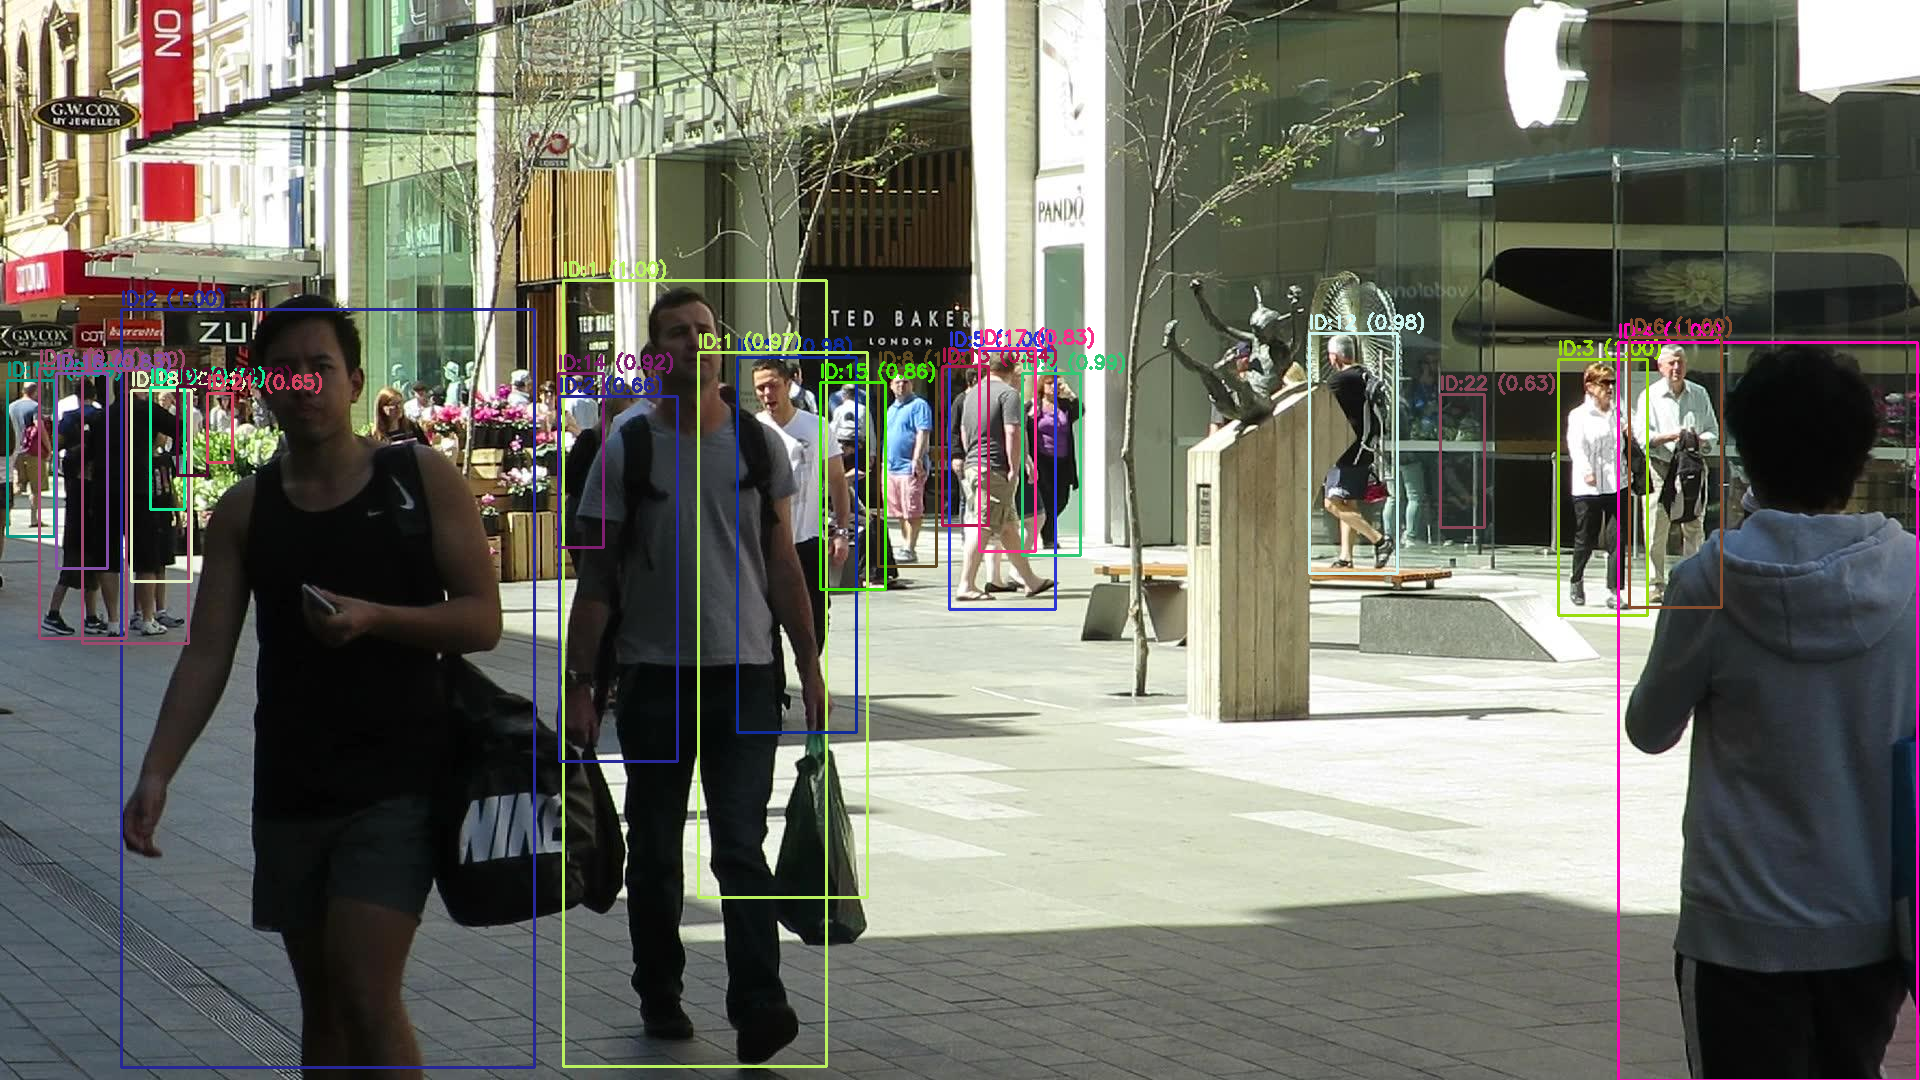


First Frame - Available IDs (Confidence >= 0.5)

>>> Available Track IDs in first frame: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
>>> Total unique IDs across all frames: 5423


In [ ]:
# Interactive Click-to-Track: Select a person and generate video
# Shows first frame with all detections, then enter the ID you want to track
# No inference needed - uses pre-computed data from previous cell

import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

# ============ CONFIGURATION ============
CONFIDENCE_THRESHOLD = 0.5  # Adjust this to filter detections by score
# =======================================

# Load pre-computed tracking data
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
TRACKING_DATA_PATH = ART / "tracking_data" / f"{SEQUENCE_NAME.lower()}_tracks.pkl"
with open(TRACKING_DATA_PATH, 'rb') as f:
    tracking_data = pickle.load(f)

print(f"Loaded tracking data: {len(tracking_data['frame_paths'])} frames")
w, h = tracking_data["frame_size"]

# Get first frame data
first_frame_path = tracking_data["frame_paths"][0]
first_boxes = tracking_data["boxes"][0].copy()
first_scores = tracking_data["scores"][0].copy()
first_track_ids = tracking_data["track_ids"][0].copy()

# Filter by confidence threshold for display
mask = first_scores >= CONFIDENCE_THRESHOLD
display_boxes = first_boxes[mask]
display_scores = first_scores[mask]
display_track_ids = first_track_ids[mask]

# Generate colors for each track ID
np.random.seed(42)
all_track_ids = set()
for ids in tracking_data["track_ids"]:
    all_track_ids.update(ids.tolist() if len(ids) > 0 else [])
colors = {tid: tuple((np.random.rand(3) * 255).astype(int).tolist()) for tid in all_track_ids}

# Draw boxes on first frame and display
first_frame = cv2.imread(first_frame_path)
first_frame_display = first_frame.copy()

for box, score, track_id in zip(display_boxes, display_scores, display_track_ids):
    x1, y1, x2, y2 = map(int, box)
    color = colors.get(int(track_id), (0, 255, 0))
    cv2.rectangle(first_frame_display, (x1, y1), (x2, y2), color, 2)
    cv2.putText(first_frame_display, f"ID:{int(track_id)} ({score:.2f})", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display using PIL/IPython for Colab
from IPython.display import display
from PIL import Image as PILImage

# Convert BGR to RGB and display
first_frame_rgb = cv2.cvtColor(first_frame_display, cv2.COLOR_BGR2RGB)
pil_img = PILImage.fromarray(first_frame_rgb)
display(pil_img)
print(f"\nFirst Frame - Available IDs (Confidence >= {CONFIDENCE_THRESHOLD})")

# Print available IDs
available_ids = sorted(set(display_track_ids.astype(int).tolist()))
print(f"\n>>> Available Track IDs in first frame: {available_ids}")
print(f">>> Total unique IDs across all frames: {len(all_track_ids)}")


### Takes the pre-computed .pkl file and finds the IDs with the most time on screen (Kind of useful when finding "good" ID candidates)

In [ ]:
import pickle
import numpy as np
from pathlib import Path
from collections import Counter

# ============ CONFIGURATION ============
# Ensure this matches the file you just saved
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
TRACKING_DATA_DIR = ART / "tracking_data"
TRACKING_DATA_PATH = TRACKING_DATA_DIR / f"{SEQUENCE_NAME.lower()}_tracks.pkl"
# =======================================

def analyze_track_persistence(pkl_path):
    if not pkl_path.exists():
        print(f"Error: File not found at {pkl_path}")
        return

    print(f"Loading data from {pkl_path}...")
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    # data['track_ids'] is a list of numpy arrays (one array per frame)
    # We flatten this list into a single list of all ID occurrences
    all_ids = []
    total_frames = len(data['track_ids'])

    for ids_in_frame in data['track_ids']:
        # Check if the array is not empty
        if len(ids_in_frame) > 0:
            all_ids.extend(ids_in_frame.tolist())

    # Count occurrences
    id_counts = Counter(all_ids)

    # Sort by frequency (most frames to least frames)
    most_common = id_counts.most_common()

    print(f"\n====== TRACKING ANALYSIS FOR {SEQUENCE_NAME} ======")
    print(f"Total Video Frames: {total_frames}")
    print(f"Total Unique Tracks: {len(most_common)}")
    print("-" * 45)
    print(f"{'Track ID':<10} | {'Frames Present':<15} | {'% of Video':<10}")
    print("-" * 45)

    # Print the top 20 most persistent tracks
    for track_id, count in most_common[:20]:
        percentage = (count / total_frames) * 100
        print(f"{track_id:<10} | {count:<15} | {percentage:.1f}%")

    return most_common

# Run the analysis
sorted_tracks = analyze_track_persistence(TRACKING_DATA_PATH)

Loading data from /content/drive/My Drive/CS5567_Deep_Learning_Project/tracking_data/mot16-08_tracks.pkl...

====== TRACKING ANALYSIS FOR MOT16-08 ======
Total Video Frames: 625
Total Unique Tracks: 5423
---------------------------------------------
Track ID   | Frames Present  | % of Video
---------------------------------------------
118        | 573             | 91.7%
335        | 470             | 75.2%
75         | 438             | 70.1%
93         | 388             | 62.1%
67         | 371             | 59.4%
124        | 354             | 56.6%
919        | 319             | 51.0%
354        | 311             | 49.8%
3396       | 288             | 46.1%
471        | 285             | 45.6%
1055       | 271             | 43.4%
486        | 268             | 42.9%
45         | 252             | 40.3%
2398       | 249             | 39.8%
364        | 245             | 39.2%
288        | 241             | 38.6%
683        | 236             | 37.8%
304        | 233             | 37

## Uses the pre-computed .pkl file to just draw the bounding boxes for the selected ID

In [ ]:
# Generate video for a specific Track ID
# Set SELECTED_TRACK_ID to the ID you want to track from the image above

# ============ CONFIGURATION ============
SELECTED_TRACK_ID = 1  # <-- Change this to the ID you want to track
CONFIDENCE_THRESHOLD = 0.7  # Same threshold as display cell
# =======================================

output_path = ART / f"siamese_reid_{SEQUENCE_NAME.lower()}_id{SELECTED_TRACK_ID}.mp4"

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
out = cv2.VideoWriter(str(output_path), fourcc, fps, (w, h))

# Get color for this track
color = colors.get(SELECTED_TRACK_ID, (0, 255, 0))

print(f"Generating video for Track ID: {SELECTED_TRACK_ID}")
for i, frame_path in enumerate(tqdm(tracking_data["frame_paths"], desc="Generating video")):
    img = cv2.imread(frame_path)

    boxes = tracking_data["boxes"][i]
    scores = tracking_data["scores"][i]
    track_ids = tracking_data["track_ids"][i]

    # Draw only the selected track ID (with confidence filter)
    for box, score, tid in zip(boxes, scores, track_ids):
        if int(tid) == SELECTED_TRACK_ID and score >= CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"ID:{int(tid)} {score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    out.write(img)

out.release()
print(f"\n[OK] Video saved to: {output_path}")


Generating video for Track ID: 364


Generating video: 100%|██████████| 625/625 [00:08<00:00, 70.22it/s]


[OK] Video saved to: /content/drive/My Drive/CS5567_Deep_Learning_Project/siamese_reid_mot16-08_id364.mp4


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# YOLO Implementation

In [ ]:
import os
import numpy as np
from pathlib import Path
from typing import Dict, Tuple, List
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

# 2. Define Paths
# The folder in your Drive where the 'train' and 'test' folders live
DRIVE_MOT_DIR = Path("/content/drive/My Drive/MOT16")

# The local spot Colab expects the data to be
LOCAL_MOT_DIR = Path("/content/MOT16")

# 3. Link Drive Data to Colab
# If you have the folders in Drive, we create a link so Colab sees them at /content/MOT16
if DRIVE_MOT_DIR.exists():
    print(f"Found MOT16 data in Drive at: {DRIVE_MOT_DIR}")

    # Remove any existing local folder to avoid conflicts
    if LOCAL_MOT_DIR.exists() or os.path.islink(LOCAL_MOT_DIR):
        !rm -rf "{LOCAL_MOT_DIR}"

    # Create the symbolic link (Shortcut)
    !ln -s "{DRIVE_MOT_DIR}" "{LOCAL_MOT_DIR}"
    print("Successfully linked Drive data to /content/MOT16")

    # Define TRAIN/TEST roots based on the link
    TRAIN_ROOT = LOCAL_MOT_DIR / 'train'
    TEST_ROOT  = LOCAL_MOT_DIR / 'test'

else:
    print(f"ERROR: Could not find 'MOT16' folder at {DRIVE_MOT_DIR}")
    print("Please update the 'DRIVE_MOT_DIR' path in this cell to match where your train/test folders are.")
    # Fallback so variables exist even if error (prevents NameError crash later)
    TRAIN_ROOT = Path("ERROR")

# 4. Define Helper Functions (Required for YOLO setup)
def list_sequences(root: Path):
    if not root.exists(): return []
    return sorted([p for p in root.iterdir() if p.is_dir()])

def parse_gt_file(
    file_path: Path,
    keep_class_ids: Tuple[int, ...] = (1,),
    vis_min: float = 0.0,
) -> Dict[int, np.ndarray]:
    frames = {}
    with file_path.open("r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 9: continue

            frame_id = int(parts[0])
            track_id = int(parts[1])
            x, y, w, h = map(float, parts[2:6])
            conf       = float(parts[6])
            class_id   = int(parts[7])
            vis        = float(parts[8])

            if class_id not in keep_class_ids: continue
            if conf < 1.0: continue
            if vis < vis_min: continue

            frames.setdefault(frame_id, []).append([track_id, x, y, w, h, class_id])

    return {fid: np.array(rows, dtype=np.float32) for fid, rows in frames.items()}

# 5. Re-create List Variables (Required for YOLO setup)
if TRAIN_ROOT.exists() and list_sequences(TRAIN_ROOT):
    train_seqs_all = list_sequences(TRAIN_ROOT)
    val_seqs   = [train_seqs_all[-1]]
    train_seqs = train_seqs_all[:-1]
    print(f"Setup Complete: {len(train_seqs)} training sequences, {len(val_seqs)} validation sequence.")
else:
    print("Setup Check: Could not find sequences. Check if 'train' folder is inside your Drive MOT16 folder.")

Mounted at /content/drive
Found MOT16 data in Drive at: /content/drive/My Drive/MOT16
Successfully linked Drive data to /content/MOT16
Setup Complete: 6 training sequences, 1 validation sequence.


## Convert MOT to YOLO and train on YOLO v8

In [ ]:
# === Rebuild YOLO dataset from MOT16 ===
import shutil
from pathlib import Path
import yaml
from PIL import Image
import numpy as np

YOLO_ROOT   = Path("/content/yolo_dataset")
PROJECT_DIR = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")

# Start fresh
if YOLO_ROOT.exists():
    shutil.rmtree(YOLO_ROOT)

(YOLO_ROOT / "images/train").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "labels/train").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "images/val").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "labels/val").mkdir(parents=True, exist_ok=True)

def convert_mot_to_yolo_fixed(seq_list, split="train", vis_min=0.3):
    """
    MOT16 → YOLO:
      - uses ALL frames (including negatives)
      - clamps boxes to image boundaries
      - optionally filters low-visibility boxes
    """
    print(f"Converting {len(seq_list)} sequences for {split} with negatives + clamping...")

    for seq_dir in seq_list:
        img_dir = seq_dir / "img1"
        gt_path = seq_dir / "gt" / "gt.txt"

        if not img_dir.exists():
            print(f"  [WARN] Missing img1 folder for {seq_dir}")
            continue

        # Ground truth (or empty)
        if gt_path.exists():
            gt_data = parse_gt_file(gt_path, vis_min=vis_min)
        else:
            gt_data = {}

        first_img = next(img_dir.glob("*.jpg"), None)
        if first_img is None:
            print(f"  [WARN] No images found in {img_dir}")
            continue

        with Image.open(first_img) as im:
            W, H = im.size

        all_imgs = sorted(img_dir.glob("*.jpg"))

        for img_path in all_imgs:
            frame_id = int(img_path.stem)

            dst_img_name = f"{seq_dir.name}_{frame_id:06d}.jpg"
            dst_img_path = YOLO_ROOT / "images" / split / dst_img_name

            if not dst_img_path.exists():
                shutil.copy(img_path, dst_img_path)

            boxes = gt_data.get(frame_id, np.empty((0, 6), dtype=np.float32))
            label_file = YOLO_ROOT / "labels" / split / dst_img_name.replace(".jpg", ".txt")

            with open(label_file, "w") as f:
                for box in boxes:
                    # [track_id, x1, y1, w, h, class_id]
                    x1, y1, w_orig, h_orig = box[1], box[2], box[3], box[4]
                    x2, y2 = x1 + w_orig, y1 + h_orig

                    # clamp
                    x1 = max(0, min(x1, W - 1))
                    y1 = max(0, min(y1, H - 1))
                    x2 = max(0, min(x2, W - 1))
                    y2 = max(0, min(y2, H - 1))

                    w = x2 - x1
                    h = y2 - y1
                    if w <= 1 or h <= 1:
                        continue

                    x_center = (x1 + w / 2) / W
                    y_center = (y1 + h / 2) / H
                    w_norm   = w / W
                    h_norm   = h / H

                    f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

# Build train/val sets
convert_mot_to_yolo_fixed(train_seqs, split="train", vis_min=0.3)
convert_mot_to_yolo_fixed(val_seqs,   split="val",   vis_min=0.3)

# Write data.yaml
data_yaml = {
    "path": str(YOLO_ROOT),
    "train": "images/train",
    "val": "images/val",
    "nc": 1,
    "names": ["pedestrian"],
}
with open(YOLO_ROOT / "data.yaml", "w") as f:
    yaml.dump(data_yaml, f)

print("Fixed Data Conversion Complete.")
print("Exists:", (YOLO_ROOT / 'data.yaml').exists())


Converting 6 sequences for train with negatives + clamping...
Converting 1 sequences for val with negatives + clamping...
Fixed Data Conversion Complete.
Exists: True


In [ ]:
# Install Ultralytics
!pip install ultralytics

from ultralytics import YOLO

# Define the save location (your Google Drive project folder)
ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")

# Load a model
# yolov8n.pt is Nano (fastest), yolov8s.pt is Small (better accuracy)
# 'yolov8s.pt' or 'yolov8m.pt' if VRAM allows.
model = YOLO('yolov8s.pt')

# Train the model
results = model.train(
    data=str(YOLO_ROOT / "data.yaml"),
    epochs=40,
    imgsz=640,
    batch=16,
    patience=10,
    cos_lr=True,
    project=str(ART),
    name='yolo_mot16_fixed',
    exist_ok=True
)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_mot16_fixed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective

In [ ]:
from ultralytics import YOLO
from pathlib import Path

ART = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
best_weights = ART / "yolo_mot16_fixed" / "weights" / "best.pt"

model = YOLO(str(best_weights))   # use fine-tuned model, not raw yolov8s.pt

## Use YOLO's built in tracker (bytetrack (speed) or botsort(accuracy))

In [ ]:
# Run tracking on a video (or image folder)
# This handles detection AND ID assignment automatically
results = model.track(
    source="/content/MOT16/test/MOT16-03/img1", # Example test sequence
    conf=0.5,
    iou=0.5,
    show=False,
    save=True,  # Saves the video with boxes and IDs
    tracker="botsort.yaml" # bytetrack.yaml or botsort.yaml
)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1500 /content/MOT16/test/MOT16-03/img1/000001.jpg: 384x640 56 pedestrians, 72.3ms
image 2/1500 /content/MOT16/test/MOT16-03/img1/000002.jpg: 384x640 54 pedestrians, 7.9ms
image 3/1500 /content/MOT16/test/MOT16-03/img1/000003.jpg: 384x640 54 pedestrians, 8.9ms
image 4/1500 /content/MOT16/test/MOT16-03/img1/000004.jpg: 384x640 56 pedestrians, 11.7ms
image 5/1500 /content/MOT16/test/MOT16-03/img1/000005.jpg: 384x640 55 pedestrians, 7.6ms
image 6/1

In [ ]:
import json

def export_yolo_detections(model, val_seqs, out_path):
    results_list = []

    # Iterate through your validation sequences
    for seq in val_seqs:
        img_dir = seq / "img1"
        img_files = sorted(img_dir.glob("*.jpg"))

        # Run inference
        for img_file in img_files:
            frame_id = int(img_file.stem)

            # Predict
            results = model(img_file, verbose=False)[0]

            boxes = []
            scores = []

            # Extract boxes
            for box in results.boxes:
                # xyxy format
                coords = box.xyxy[0].cpu().numpy().tolist()
                conf = float(box.conf[0].cpu())

                boxes.append(coords)
                scores.append(conf)

            results_list.append({
                "image_id": frame_id,
                "seq_name": seq.name,  # avoids confusion between videos
                "boxes": boxes,
                "scores": scores
            })

    with open(out_path, "w") as f:
        for res in results_list:
            f.write(json.dumps(res) + "\n")

    print(f"Saved YOLO detections to {out_path}")

# Use this file to feed your existing Re-ID tracker
export_yolo_detections(model, val_seqs, ART / "detections_val_yolo2.jsonl")

Saved YOLO detections to /content/drive/My Drive/CS5567_Deep_Learning_Project/detections_val_yolo2.jsonl


## Test YOLO implementation

## Convert MOT16 to video

In [ ]:
import cv2
import os

def images_to_video(img_folder, output_file, fps=30):
    """
    Stitches a folder of images into a video file.
    """
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".jpg")])
    if not img_files:
        print(f"No images found in {img_folder}")
        return

    # Read first image to get dimensions
    first_img = cv2.imread(os.path.join(img_folder, img_files[0]))
    height, width, layers = first_img.shape

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # or 'XVID' for .avi
    video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    print(f"Creating video {output_file} from {len(img_files)} frames...")

    for fname in img_files:
        video.write(cv2.imread(os.path.join(img_folder, fname)))

    cv2.destroyAllWindows()
    video.release()
    print("Video created successfully.")

# --- Action: Convert a specific Test Sequence ---
# Choose a sequence from /content/MOT16/test/ (e.g., MOT16-03 is a popular night street scene)
test_seq_name = "MOT16-03"
source_folder = f"/content/MOT16/test/{test_seq_name}/img1"
input_video_path = f"/content/{test_seq_name}_input2.mp4"

images_to_video(source_folder, input_video_path, fps=30)

Creating video /content/MOT16-03_input2.mp4 from 1500 frames...
Video created successfully.


## Run the tracker

In [ ]:
# source: The video we just created above
# save: True (saves the video to disk)
# project/name: Where to save the output
results = model.track(
    source=input_video_path,
    conf=0.4,     # Confidence threshold - this will need to be tuned if we miss people
    iou=0.5,      # NMS IoU threshold
    tracker="botsort.yaml", # Built-in YOLO tracker
    show=False,
    save=True,
    project="/content/drive/My Drive/CS5567_Deep_Learning_Project",
    name="final_tracking_results"
)

print("Tracking complete. Check the folder above for your video.")

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/drive/My Drive/CS5567_Deep_Learning_Project/final_tracking_results2
Tracking complete. Check the folder above for your video.


# YOLO Final - Get and copy Botsort config

In [ ]:
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Create video tracing 1 person

## Edit botsort parameters for single person tracking

In [ ]:
# Install Ultralytics
!pip install ultralytics

import ultralytics, os, inspect, shutil
from pathlib import Path
import yaml

# 1 Copy botsort.yaml to a writable location
ultra_dir = os.path.dirname(inspect.getfile(ultralytics))
botsort_src = os.path.join(ultra_dir, "cfg", "trackers", "botsort.yaml")
botsort_custom = Path("/content/botsort_custom.yaml")

shutil.copy(botsort_src, botsort_custom)
print("Copied BoT-SORT config to:", botsort_custom)

# 2 Tune it for occlusion robustness
with open(botsort_custom, "r") as f:
    cfg = yaml.safe_load(f)

cfg["track_buffer"] = 120          # allow ~4 seconds of disappearances; track at 30 FPS
if "match_thresh" in cfg:
    cfg["match_thresh"] = 0.7      # more forgiving re-association

# optional, only if present in your YAML
if "proximity_thresh" in cfg:
    cfg["proximity_thresh"] = 0.2
else:
    print("proximity_thresh not found")

if "appearance_thresh" in cfg:
    cfg["appearance_thresh"] = 0.3
else:
    print("appearance_thresh not found")

with open(botsort_custom, "w") as f:
    yaml.safe_dump(cfg, f)

print("Updated BoT-SORT config.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Copied BoT-SORT config to: /content/botsort_custom.yaml
Updated BoT-SORT config.


## Use config and fine-tuned weights

In [ ]:
import os, cv2, numpy as np
from pathlib import Path
from ultralytics import YOLO

ART      = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
MOT_ROOT = Path("/content/drive/My Drive/MOT16")

# 1 Load weights - best -> last -> base
run_dir     = ART / "yolo_mot16_fixed"
weights_dir = run_dir / "weights"
best_weights = weights_dir / "best.pt"
last_weights = weights_dir / "last.pt"

if best_weights.exists():
    weights_path = best_weights
    print("Using best weights:", weights_path)
elif last_weights.exists():
    weights_path = last_weights
    print("best.pt not found, using last.pt:", weights_path)
else:
    weights_path = "yolov8s.pt"
    print("WARNING: No fine-tuned weights found, using base yolov8s.pt")

model = YOLO(str(weights_path))

# 2 Build video from MOT16-03/img1
def images_to_video(img_folder, output_file, fps=30):
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".jpg")])
    if not img_files:
        raise FileNotFoundError(f"No .jpg files in {img_folder}")
    first_img = cv2.imread(os.path.join(img_folder, img_files[0]))
    h, w, _ = first_img.shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video  = cv2.VideoWriter(output_file, fourcc, fps, (w, h))
    print(f"Creating video {output_file} from {len(img_files)} frames...")
    for fname in img_files:
        frame = cv2.imread(os.path.join(img_folder, fname))
        video.write(frame)
    video.release()
    cv2.destroyAllWindows()
    print("Video created successfully.")

test_seq_name = "MOT16-03"
source_folder = MOT_ROOT / "test" / test_seq_name / "img1"  # <- matches your screenshot
print("Using frames from:", source_folder, "exists:", source_folder.exists())

input_video_path = f"/content/{test_seq_name}_input2.mp4"
images_to_video(str(source_folder), input_video_path, fps=30)

# 3 Track and draw ONLY ID 15
botsort_cfg = str(botsort_custom)

output_video_path = str(ART / "id15_tracking_demo.mp4")
fps = 30
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = None

for res in model.track(
        source=input_video_path,
        conf=0.25,
        iou=0.7,
        tracker=botsort_cfg,
        stream=True,
        verbose=False):

    frame = res.orig_img.copy()
    boxes = res.boxes

    if boxes.id is not None:
        ids  = boxes.id.cpu().numpy().astype(int)
        xyxy = boxes.xyxy.cpu().numpy().astype(int)
        for (x1, y1, x2, y2), tid in zip(xyxy, ids):
            if tid == 15:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
                cv2.putText(frame, "ID 15",
                            (x1, max(0, y1 - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 255), 2)

    if writer is None:
        h, w = frame.shape[:2]
        writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))
    writer.write(frame)

if writer is not None:
    writer.release()

print("Saved single-person tracking video to:", output_video_path)


Using best weights: /content/drive/My Drive/CS5567_Deep_Learning_Project/yolo_mot16_fixed/weights/best.pt
Using frames from: /content/drive/My Drive/MOT16/test/MOT16-03/img1 exists: True
Creating video /content/MOT16-03_input2.mp4 from 1500 frames...
Video created successfully.
Saved single-person tracking video to: /content/drive/My Drive/CS5567_Deep_Learning_Project/id15_tracking_demo.mp4


In [ ]:
from ultralytics import YOLO
from pathlib import Path
import os, cv2, numpy as np

ART      = Path("/content/drive/My Drive/CS5567_Deep_Learning_Project")
MOT_ROOT = Path("/content/drive/My Drive/MOT16")   # <-- root of MOT16 on Drive

# Training run directory (set by project=ART, name='yolo_mot16_fixed')
run_dir     = ART / "yolo_mot16_fixed"
weights_dir = run_dir / "weights"

best_weights = weights_dir / "best.pt"
last_weights = weights_dir / "last.pt"

# Prefer best.pt, fall back to last.pt, else raw yolov8s
if best_weights.exists():
    weights_path = best_weights
    print("Using best weights:", weights_path)
elif last_weights.exists():
    weights_path = last_weights
    print("best.pt not found, using last.pt:", weights_path)
else:
    weights_path = "yolov8s.pt"
    print("WARNING: No fine-tuned weights found, using base yolov8s.pt")

model = YOLO(str(weights_path))

# ---------- build input video from MOT16-03/img1 ----------
def images_to_video(img_folder, output_file, fps=30):
    """
    Stitches a folder of images into a video file.
    """
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".jpg")])
    if not img_files:
        raise FileNotFoundError(f"No images found in {img_folder}")

    first_img = cv2.imread(os.path.join(img_folder, img_files[0]))
    height, width, _ = first_img.shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video  = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    print(f"Creating video {output_file} from {len(img_files)} frames...")
    for fname in img_files:
        frame = cv2.imread(os.path.join(img_folder, fname))
        video.write(frame)

    video.release()
    cv2.destroyAllWindows()
    print("Video created successfully.")

test_seq_name = "MOT16-03"
source_folder = MOT_ROOT / "test" / test_seq_name / "img1"   # <-- THIS is the fix
print("Using frames from:", source_folder, "exists:", source_folder.exists())

input_video_path = f"/content/{test_seq_name}_input2.mp4"
images_to_video(str(source_folder), input_video_path, fps=30)

# track and highlight only ID 15
output_video_path = str(ART / "id15_tracking_demo.mp4")
fps = 30
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = None

for res in model.track(
        source=input_video_path,
        conf=0.25,                 # lower for better recall
        iou=0.7,
        tracker=str(botsort_custom),
        stream=True,
        verbose=False):

    frame = res.orig_img.copy()
    boxes = res.boxes

    if boxes.id is not None:
        ids  = boxes.id.cpu().numpy().astype(int)
        xyxy = boxes.xyxy.cpu().numpy().astype(int)

        for (x1, y1, x2, y2), tid in zip(xyxy, ids):
            if tid == 15:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
                cv2.putText(frame, "ID 15",
                            (x1, max(0, y1 - 10)),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 255), 2)

    if writer is None:
        h, w = frame.shape[:2]
        writer = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    writer.write(frame)

if writer is not None:
    writer.release()

print("Saved single-person tracking video to:", output_video_path)


Using best weights: /content/drive/My Drive/CS5567_Deep_Learning_Project/yolo_mot16_fixed/weights/best.pt
Using frames from: /content/drive/My Drive/MOT16/test/MOT16-03/img1 exists: True
Creating video /content/MOT16-03_input2.mp4 from 1500 frames...
Video created successfully.
Saved single-person tracking video to: /content/drive/My Drive/CS5567_Deep_Learning_Project/id15_tracking_demo.mp4
